**Introduction:**

Using simple random search. In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 

Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a normal distribution.

$$ FR+ = FR - \frac{\nu}{N\delta} \sum_{n = 1}^N ( error(FR + \delta p) - error(FR) ) \cdot  p, p \sim \mathcal{N}(0,\sigma^2) $$

Note: p is a perturbation taken from a distribution with mean = 0

References:

[1] G. Cauwenberghs, “A Fast Stochastic Error-Descent Algorithm for Supervised Learning and Optimization,” in Advances in Neural Information Processing Systems 5, S. J. Hanson, J. D. Cowan, and C. L. Giles, Eds. Morgan-Kaufmann, 1993, pp. 244–251.

[2] R. Héliot, K. Ganguly, J. Jimenez, and J. M. Carmena, “Learning in Closed-Loop Brain–Machine Interfaces: Modeling and Experimental Validation,” IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 40, no. 5, pp. 1387–1397, Oct. 2010, doi: 10.1109/TSMCB.2009.2036931.


__Test Cases:__

1. Try ideal scenario: KW = Identity matrix, A = 0, B = 0
2. Limit number of neurons to 2
3. Test SGD against simple cost function ($y = x^2$)
4. Ideal scenario with A/B: KW = I, A - Kb = 0

In [1]:
import numpy as np
from numpy import linalg
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set()


### Brain Modeling

In [2]:
# Brain Model 
###################
# Function that calculates firing rate from b, W, t
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (2.a, 2.b) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# targ_vect = 2 x 1
## OUTPUT
# newFR = N x 1
def brainFiringRate(lambda_vect, targ_vect):
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1)
    newFR = np.zeros( (np.size(lambda_vect, 0), 1) )
    newFR[:, 0] = np.matmul(lambda_vect, targ_vect_mult)
    return newFR

#********
# Passed test:
# lambda_vect = np.array([[1, 2, 3], [4, 5, 6], [7,8,9], [10, 11, 12]])
# targ_vect = np.array([1, 2])
# brainFiringRate(lambda_vect, targ_vect) = b + Wt
#********


###################
# Function that alters the lambda paramters (b, W) for the brain
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (6) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# delta_perturb = N x 1  
# targ_vect = 2 x 1
## MIDDLE
# targ_vect_mult = 3 x 1 [1 t_x t_y]'
# targ_matx = N x 3
# delta_matx = N x 3
# next_term = delta_matx*delta_matx (element-wise mult) = N x 3
## OUTPUT
# lambda_vect_new = N x 3

def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
    # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
    num_neurons = np.size(lambda_vect.copy(), 0)
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1) # 3 x 1  
    targ_matx = (np.matlib.repmat(targ_vect_mult, num_neurons, 1)) # N x 3

    # next gradient term: \gamma*delta_perturb
    delta_matx = np.matlib.repmat(delta_perturb, 1, 3) # N x 3
    next_term = (delta_matx*targ_matx) # 3 x N
    lambda_vect_new = lambda_vect.copy() - (gamma*next_term)
    return lambda_vect_new

#********
# Passed test:
# lambda_vect = np.array([[1, 2, 3], [4, 5, 6], [7,8,9], [10, 11, 12]])
# targ_vect = np.array([1, 2])
# gamma = 0.5
# delta_perturb = np.array([[4], [5], [6], [7]])
# calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect) = lambda_vect - (gamma*error grad*[1 tx ty])
#********

### Decoder Model

In [3]:
####################
# Decoder Model 
# Affine Function that calculates target postion from firing rate
# Y = D(f) = a + Kf --> Weiner Filter
# This is Equation (1) in Heliot et al, 2010

## INPUT
# N = number of neurons, d = dimension of target
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
# targ_vect = target position (T_x, Y_y)
## OUTPUT
# Cursor position = Y_x, Y_y
def decoder_findY(decoder_params, brain_params):
    # check firing rate 
    # Start with affine decoder
    (a_vect_in, k_matx_in) = decoder_params
    (fr_curr, targ) = brain_params
    a_vect = a_vect_in.copy()
    k_matx = k_matx_in.copy()
    cursor_pos = np.zeros( (NUM_DIM, 1))
    cursor_pos = a_vect.reshape(NUM_DIM, 1) +  (np.matmul(k_matx, fr_curr))
    return (cursor_pos)

#********
# Passed Test: 
# a = np.array([-10, -20])
# k = np.random.random([2, 4])
# NUM_DIM = 2
# fr = brainFiringRate(lambda_vect, targ_vect)
# decoder_params = (a, k)
# brain_params = (fr, targ_vect)
# pos = decoder_findY(decoder_params, brain_params) = a + Kf
#********


# Function uses stochastic gradient descent to adjust decoder parameters
## INPUT
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
## OUTPUT
# next decoder parameters = a_next, k_next
def calcNextDecoder(decoder_params, brain_vars):
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    cost_func_args = ( (a_vect, k_matx), brain_vars)
    # a vector
    if (ADAPT_DEC == True):
        a_grad = findErrorGrad(a_vect.copy(), A_VAR, a_dist, error_costFunc, cost_func_args)
        k_grad = findErrorGrad(k_matx.copy(), K_VAR, k_dist, error_costFunc, cost_func_args)
        a_next = a_vect.copy().reshape(np.shape(a_grad)) - a_rate*a_grad
        k_next = k_matx.copy() - k_rate*k_grad
    else:
        a_next = a_vect
        k_next = k_matx

    return (a_next, k_next)

#*******
# TODO: Test this function
#*******

### Reach Error

In [4]:
####################
# Reach error
# This is Equation (3) in Heliot et al, 2010

## INPUT
# y_x, y_y = predicted cursor position
# t_x, t_y = target position
## OUTPUT
# norm squared of (target position - cursor position)
# this returns the square of distance between the two position points
# where reach error is the target position - cursor position
def calcReachError(y_vect, t_vect):
    norm_vect = np.array(y_vect).reshape(NUM_DIM,1) - np.array(t_vect).reshape(NUM_DIM, 1)
    return (np.linalg.norm(norm_vect, 2)**2)

#*******
# Failed test:
# Had to add .reshape(NUM_DIM, 1) to the norm vect
# Update:
# Passed Test
#*******

## INPUT
# cost_func_params = decoder params (a vect, k matx) and current firing rate
## OUTPUT
# reach error = scalar; norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def error_costFunc(cost_func_params):
    (decoder_params, brain_vars) = cost_func_params
    (fr_curr, targ_vect) = brain_vars
    y_vect = decoder_findY(decoder_params, brain_vars)
    t_vect = targ_vect
    return calcReachError(y_vect, t_vect)  


### Stochastic Error Descent: Update Calculation

In [5]:
import random
import time


## Stochastic Error Descent
# This is Equation (4) and Equation (5) in Heliot, 2010
# Derivation is found in Cauwenberghs, 1993 

# This function is one iteration of the error descent calcuation
## INPUT
# input_vect = vector to stochastically perturb
# input_var = FR_VAR, A_VAR OR K_VAR 
# param_dist = distribution from which perturbations to the input are selected
# cost_func = cost function (always reach error)
# cost_func_args = arguments to the cost function (depends on error cost function)
## OUTPUT
# errorGrad = gradient for updating parameter (input vect)
def findErrorGrad(input_vect, input_var, param_dist, cost_func, cost_func_args):
    # Un-nest everything
    (sigma, delta, num_dist) = param_dist
    (decoder_params, (curr_fr, targ_vect) ) = cost_func_args
    (a_vect, k_matx) = decoder_params
    
    # Get size of input vector
    num_neurons = np.size(k_matx, 1)
    num_input_row = np.size(input_vect, 0) 
    num_input_column = 1
    if (input_vect.ndim > 1): 
        num_input_column = np.size(input_vect, 1)
    
    # What to perturb and input firing rate for error cost function
    input_vect = input_vect.copy().reshape(num_input_row, num_input_column)
    input_fr = curr_fr.copy().reshape(num_neurons, 1)
       
    error_sum = np.zeros((num_input_row, 1)) 
    error_grad = np.zeros((num_input_row, 1))
    perturb_rand = np.random.uniform(-sigma, sigma, [num_input_row, num_input_column, num_dist])
    

# Normalizes the stochastic perturbations to 1 and then multiplies by sigma, so perturb_rand = +/- sigma
#     perturb_rand /= np.linalg.norm(perturb_rand,axis=1)[:,np.newaxis]
#     perturb_rand *= sigma

    for iD in range(num_dist):
        # perturb_vect = stochastic pertrbation (amount of stochastic descent perturbation)
        perturb_vect = np.squeeze(perturb_rand[:, :, [iD]])
        perturb_vect = perturb_vect.copy().reshape(num_input_row, num_input_column)
        
        # find the delta error caused by the perturbation (direction to descend gradient in) 
        input_perturb = np.add(input_vect, delta*perturb_vect) 
        
        # Case 1: firing rate
        # error = reachError(a + K*fr')
        if (input_var == FR_VAR):        
            # Calculate error 
            perturb_cost_args = (decoder_params, (input_perturb, targ_vect) ) 
            
        # case 2: a
        # error = reachError(a' + K*fr)
        elif (input_var == A_VAR):
            decoder_params_perturb = (input_perturb, k_matx)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))

        # case 3: k
        # error = reachError(a + K'*fr)
        elif (input_var == K_VAR):
            decoder_params_perturb = (a_vect, input_perturb)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))   
        
        # default: do nothing
        else:
            perturb_cost_args = cost_func_args
        
        error_perturb = cost_func(perturb_cost_args)   
        error_input = cost_func(cost_func_args)
        error_sum = np.add(error_sum, (error_perturb - error_input)*perturb_vect)

#     error_grad = np.array(error_sum/(num_dist*delta*(sigma**2)))
    error_grad = np.array(error_sum/(num_dist*delta))
    return error_grad

### Stochastic Gradient Descent: Update Step and Recalculate Error

In [6]:
# Old code

# # This function goes through and updates brain paramters over the num_iter times
# def brain_adapt_sgd(brain_params, decoder_params, targ_vect, num_iter):
#     (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
#     (fr_init, targ_vect)= brain_vars
#     (fr_sigma, fr_delta, fr_dist_size) = fr_dist
#     (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
#     decoder_init = (a_init, k_init)
#     grad_args_init = (decoder_init, brain_vars)
    

#     num_neurons = np.size(fr_init, 0)
#     runs_num = 1

#     # for sigma in sigma_list:
#     for iR in range(runs_num):
#         # Set the u vectors
#         fr_vect = np.zeros( (num_neurons, 1, num_iter) )
#         fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
# #         fr_vect[:, 0] = fr_init
#         fr_final = np.zeros((num_neurons, 1, runs_num))
#         re_final = np.zeros(runs_num)
#         lambda_final = np.zeros((num_neurons, np.size(lambda_init, 1), runs_num))

#         print("starting fr vect = " + str( fr_vect[:, :, 0] ))
#         # lambda init = N x 3
#         # lambda_vect = N x 3 X ITER
#         lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
#         lambda_vect[:,:,0] = lambda_init 

#         # set the cost vector
#         err_vect = np.zeros(num_iter)
#         err_vect[0] = error_costFunc(grad_args_init)
#         print('initial error = ' + str(err_vect[0]))

#         # calculate the initial delta e
#         grad_new = np.zeros(num_iter)
#         grad_new = findErrorGrad(fr_init, FR_VAR, fr_dist, error_costFunc, grad_args_init)

#         for iT in range(num_iter-1):
#             ## calculate the new u 
#             # (1) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
#             lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
#             lambda_vect[:,:, iT + 1] = lambda_next
            
#             # (2) fr+ = B(lambda+)
#             fr_next = brainFiringRate(lambda_next, targ_vect)
#             fr_vect[:, :, iT+1] = fr_next

#             # Update parameters for calculating error and calculate the new cost
#             # (3) Calculate the new reach error 
#             brain_vars_next = fr_next, targ_vect
#             grad_args_next = (decoder_init, brain_vars_next)
#             err_next = np.array(error_costFunc(grad_args_next))
#             err_vect[iT+1] = err_next

#             # (4) calculate the next error descent term to update FR again
#             grad_new = findErrorGrad(fr_next, FR_VAR, fr_dist, error_costFunc, grad_args_next)
        
#         fr_final[:, :, iR] = fr_next
#         re_final[iR] = err_next
#         lambda_final[:, :, iR] = lambda_next        

#     return (re_final, fr_final, lambda_final)


In [7]:
# This function goes through and updates brain paramters over the num_iter times
def calcNextBrain(brain_params, decoder_params, targ_vect, num_iter):
    # Unpack arguments that are being passed in
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
#     (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    decoder_vals = (a_vect, k_matx)
#     grad_args_init = (decoder_vals, fr_init)
    
    num_neurons = np.size(fr_init, 0)
    fr_vect = np.zeros( (num_neurons, 1, num_iter) )
    fr_final = np.zeros( np.size(fr_init) )
    fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
    
    # lambda init = N x 3
    # lambda_vect = N x 3 X ITER
    lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
    lambda_vect[:, :, 0] = lambda_init 
    lambda_final = np.zeros(np.size(lambda_init))
    
    for iT in range(num_iter-1):
        # (1) calculate the perturbation
        brain_vars = (fr_vect[:, :, iT], targ_vect)
        grad_args = (decoder_vals, brain_vars)
        grad_new = findErrorGrad(fr_vect[:, :, iT], FR_VAR, fr_dist, error_costFunc, grad_args)
       
        # (2) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
        lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
        lambda_vect[:,:, iT + 1] = lambda_next
       
        # (2) fr+ = B(lambda+)
        fr_next = brainFiringRate(lambda_next, targ_vect)
        fr_vect[:, :, iT + 1] = fr_next
       
    lambda_final = lambda_next
    fr_final = fr_next

    return  (fr_final, lambda_final)

### Generate New Trial

In [8]:
def findNextTarget(curr_cursor, prev_targ):
    ## random
    x_pos = int(np.random.random_sample()*10)
    y_pos = int(np.random.random_sample()*10)

#     x_pos = prev_targ[0][0]
#     y_pos = prev_targ[1][0]

    return np.array( [x_pos, y_pos] )

### Set initial conditions

In [9]:
########
## Set some initial conditions here

# Helper info:
# fr_init = N x 1
# lambda init = N x 3
# baseline = 1 x N
# target_vector = 2 x 1
# K_matx = 2 x N
# A = 2 x 1

NUM_NEURONS = 10
NUM_DIM = 2
NUM_LAMBDA = NUM_DIM + 1

print("INITIAL CONDITIONS")
print("NUM NEURONS = " + str(NUM_NEURONS))
# target position
TARGET_VECTOR = np.array([[1] , [1]])
# TARGET_VECTOR = np.array([[1]])
print(np.shape(TARGET_VECTOR))
print("initial target = " + str(TARGET_VECTOR))

# firing rate 
fr_init = np.zeros( (NUM_NEURONS, 1) ) 

# BASELINE (b)
BASELINE = (10*np.random.random_sample(NUM_NEURONS))  # random float [0, 10)
print("baseline shape = " + str(np.shape(BASELINE)))
print("b =" + str(BASELINE))

# decoder initial paramters
# IDEAL: y = a + Kf = a + K(b + Wt) = a + Kb + KWt
# in order for y = t, want: a + Kb --> 0 and KW --> Identity matx
K_MATX = np.random.random_sample( (NUM_DIM, NUM_NEURONS) ) # random float [0, 1)
A_VECT = (-np.matmul(K_MATX, BASELINE))
print("K MATX = " + str(K_MATX))
print("A = " + str(A_VECT))

KW_only = False #False = include A/B, True = only K/W, no baseline

# lambda
lambda_init = np.zeros((NUM_NEURONS, NUM_LAMBDA))
W_init = np.linalg.pinv(K_MATX) 
W_rand = 0*np.random.random_sample( (NUM_NEURONS, NUM_DIM) )
W_init = W_init + W_rand
lambda_init[:, 0] = np.array([BASELINE])        # lambda[0] = baseline
lambda_init[:, 1:3] = W_init
print("lambda init = ")
print(lambda_init)

# lambda_init[:, 1] = np.random.random_sample(np.shape(lambda_init[:, 0]))    # lambda[2] = w_y
# lambda_init[:, 2] = np.random.random_sample(np.shape(lambda_init[:, 0]))*10 
# # lambda_init[:, 1] = np.array([0.4, 0.6, 1, 2])  # lambda[1] = w_x
# # lambda_init[:, 2] = np.array([3, 5, 4, 2])      # lambda[2] = w_

# SGD initial parameters
# Mapping for variables
FR_VAR = 1
A_VAR = 2
K_VAR = 3

# Brain
FR_SIGMA = 1
FR_DELTA = 1
FR_DIST_SIZE = 100

# Decoder
# A_RATE = 1e-4
A_SIGMA = 1
A_DELTA = 1
A_DIST_SIZE = 100
# --
# K_RATE = 5e-4
K_SIGMA = 1
K_DELTA = 1
K_DIST_SIZE = 100

# display parameters
fig_x = 10
fig_y = 5



INITIAL CONDITIONS
NUM NEURONS = 10
(2, 1)
initial target = [[1]
 [1]]
baseline shape = (10,)
b =[8.98954463 7.77605238 4.54799726 1.45589672 2.36789729 7.2132959
 2.93466537 8.92041954 9.78301606 3.16774618]
K MATX = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]
A = [-23.27369153 -24.94904898]
lambda init = 
[[ 8.98954463 -0.2276387   0.27940092]
 [ 7.77605238  0.46341065 -0.21115086]
 [ 4.54799726 -0.10202042  0.50152162]
 [ 1.45589672  0.68279885 -0.49068326]
 [ 2.36789729  0.1889147  -0.0763208 ]
 [ 7.2132959   0.17428308  0.05819412]
 [ 2.93466537  0.29152701 -0.18707183]
 [ 8.92041954 -0.53731763  0.82468233]
 [ 9.78301606  0.44276974 -0.14688659]
 [ 3.16774618  0.03807051 -0.01367733]]


### Adaptive Decoder


+++++++++++++++++++++++++++++++++++
Session #0
target at trial 0 = [[1.]
 [1.]]
K MATX INIT= [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]
A VECT INIT = [-23.27369153 -24.94904898]
lambda
[[ 8.98954463 -0.2276387   0.27940092]
 [ 7.77605238  0.46341065 -0.21115086]
 [ 4.54799726 -0.10202042  0.50152162]
 [ 1.45589672  0.68279885 -0.49068326]
 [ 2.36789729  0.1889147  -0.0763208 ]
 [ 7.2132959   0.17428308  0.05819412]
 [ 2.93466537  0.29152701 -0.18707183]
 [ 8.92041954 -0.53731763  0.82468233]
 [ 9.78301606  0.44276974 -0.14688659]
 [ 3.16774618  0.03807051 -0.01367733]]
a
[-23.27369153 -24.94904898]
K
[[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884

 [ 3.16455066  0.02312521 -0.02905588]]
cursor end = [[8.12685924]
 [8.2180455 ]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #6 | lambda learn rate = 0.005
Target = [[0.]
 [2.]]
lambda start of trial = [[ 8.98866504 -0.23484819  0.27437095]
 [ 7.77680464  0.46687545 -0.20313287]
 [ 4.54760205 -0.10209557  0.5031266 ]
 [ 1.4542108   0.67575035 -0.49527871]
 [ 2.36938935  0.20340845 -0.05923615]
 [ 7.21602942  0.18156868  0.08434357]
 [ 2.93204005  0.27968798 -0.19811174]
 [ 8.9208459  -0.52983193  0.83313198]
 [ 9.78114268  0.43920987 -0.15166519]
 [ 3.16455066  0.02312521 -0.02905588]]
cursor start = [[0.0295306 ]
 [2.04012611]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
     

lambda end of trial = [[ 8.98793079 -0.23835291  0.26964452]
 [ 7.77607072  0.46814978 -0.20591832]
 [ 4.54481986 -0.10530739  0.49307289]
 [ 1.4532305   0.67360706 -0.49534422]
 [ 2.36613214  0.18876219 -0.07728814]
 [ 7.21479698  0.18149861  0.07205883]
 [ 2.92984591  0.26964418 -0.20709162]
 [ 8.91773828 -0.53396409  0.82737016]
 [ 9.78102832  0.44132877 -0.15556791]
 [ 3.16325891  0.01155231 -0.03925885]]
cursor end = [[2.95303352]
 [0.97724939]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #16 | lambda learn rate = 0.005
Target = [[5.]
 [4.]]
lambda start of trial = [[ 8.98793079 -0.23835291  0.26964452]
 [ 7.77607072  0.46814978 -0.20591832]
 [ 4.54481986 -0.10530739  0.49307289]
 [ 1.4532305   0.67360706 -0.49534422]
 [ 2.36613214  0.18876219 -0.07728814

lambda end of trial = [[ 8.98738992e+00 -2.38478752e-01  2.71160159e-01]
 [ 7.77675754e+00  4.73817662e-01 -2.02238434e-01]
 [ 4.54604440e+00 -9.67368352e-02  4.99131550e-01]
 [ 1.45507350e+00  6.78337071e-01 -4.90873129e-01]
 [ 2.36394786e+00  1.71244887e-01 -8.29963343e-02]
 [ 7.21671997e+00  1.88748401e-01  8.74557091e-02]
 [ 2.92881623e+00  2.67031550e-01 -2.07109326e-01]
 [ 8.91897676e+00 -5.31188590e-01  8.35134250e-01]
 [ 9.78128302e+00  4.38798810e-01 -1.56047239e-01]
 [ 3.16155909e+00  6.44679928e-03 -5.36866325e-02]]
cursor end = [[6.03180348]
 [9.15449426]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #22 | lambda learn rate = 0.005
Target = [[5.]
 [8.]]
lambda start of trial = [[ 8.98738992e+00 -2.38478752e-01  2.71160159e-01]
 [ 7.77675754e+00  4.7

 [ 3.16048605e+00  8.60207750e-03 -6.59253438e-02]]
cursor end = [[2.21066561]
 [8.24623552]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #28 | lambda learn rate = 0.005
Target = [[3.]
 [1.]]
lambda start of trial = [[ 8.98885612e+00 -2.27827335e-01  2.75263634e-01]
 [ 7.77922047e+00  4.83201393e-01 -1.87234969e-01]
 [ 4.54799408e+00 -8.53742356e-02  5.05760443e-01]
 [ 1.45728986e+00  6.87780971e-01 -4.75262110e-01]
 [ 2.36349552e+00  1.71636318e-01 -9.06080467e-02]
 [ 7.21655050e+00  1.77605854e-01  9.23388850e-02]
 [ 2.92799884e+00  2.65509174e-01 -2.15633200e-01]
 [ 8.91995950e+00 -5.28112640e-01  8.35736848e-01]
 [ 9.78084546e+00  4.32980618e-01 -1.57216546e-01]
 [ 3.16048605e+00  8.60207750e-03 -6.59253438e-02]]
cursor start = [[3.05250359]
 [1.08771882]]

lambda end of trial = [[ 8.98671638e+00 -2.43031592e-01  2.69890159e-01]
 [ 7.77754491e+00  4.76566059e-01 -2.00081366e-01]
 [ 4.54549190e+00 -9.44836641e-02  4.93843964e-01]
 [ 1.45665269e+00  6.90371763e-01 -4.76289541e-01]
 [ 2.36197398e+00  1.63160105e-01 -9.44100856e-02]
 [ 7.21479287e+00  1.73180209e-01  9.00070137e-02]
 [ 2.92757025e+00  2.66266600e-01 -2.20160754e-01]
 [ 8.91627427e+00 -5.45884318e-01  8.22267267e-01]
 [ 9.77619384e+00  4.12916313e-01 -1.79797874e-01]
 [ 3.16010620e+00  4.93883720e-03 -6.83198590e-02]]
cursor end = [[8.647536  ]
 [8.67243664]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #37 | lambda learn rate = 0.005
Target = [[2.]
 [7.]]
lambda start of trial = [[ 8.98671638e+00 -2.43031592e-01  2.69890159e-01]
 [ 7.77754491e+00  4.7

lambda end of trial = [[ 8.98695531e+00 -2.38246107e-01  2.63877274e-01]
 [ 7.77674737e+00  4.73408067e-01 -2.05351895e-01]
 [ 4.54598656e+00 -9.26471885e-02  4.97051631e-01]
 [ 1.45635180e+00  6.88470571e-01 -4.80349724e-01]
 [ 2.35997151e+00  1.53170144e-01 -9.81690982e-02]
 [ 7.21517188e+00  1.75959713e-01  9.32822249e-02]
 [ 2.92811547e+00  2.68274727e-01 -2.14020211e-01]
 [ 8.91629541e+00 -5.44717397e-01  8.22365136e-01]
 [ 9.77868886e+00  4.22209861e-01 -1.65740870e-01]
 [ 3.15897236e+00 -2.29621125e-03 -6.39482372e-02]]
cursor end = [[4.89105659]
 [0.91224829]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #43 | lambda learn rate = 0.005
Target = [[0.]
 [9.]]
lambda start of trial = [[ 8.98695531e+00 -2.38246107e-01  2.63877274e-01]
 [ 7.77674737e+00  4.7

lambda end of trial = [[ 8.98963612 -0.22576207  0.27848435]
 [ 7.77752122  0.48131692 -0.19902517]
 [ 4.54530704 -0.09048721  0.5000624 ]
 [ 1.45806456  0.69602751 -0.47406844]
 [ 2.3567116   0.13061635 -0.10954254]
 [ 7.21288513  0.18042466  0.08221843]
 [ 2.92673108  0.2616636  -0.21326115]
 [ 8.9182323  -0.53610426  0.83170087]
 [ 9.77660931  0.42025437 -0.17298126]
 [ 3.15648599 -0.01349833 -0.07765263]]
cursor end = [[ 3.93660146]
 [-0.01911689]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #49 | lambda learn rate = 0.005
Target = [[3.]
 [3.]]
lambda start of trial = [[ 8.98963612 -0.22576207  0.27848435]
 [ 7.77752122  0.48131692 -0.19902517]
 [ 4.54530704 -0.09048721  0.5000624 ]
 [ 1.45806456  0.69602751 -0.47406844]
 [ 2.3567116   0.13061635 -0.109542

lambda end of trial = [[ 8.98551898 -0.23725402  0.25888116]
 [ 7.77978562  0.48928371 -0.19939121]
 [ 4.54686202 -0.07540215  0.4954436 ]
 [ 1.45735233  0.69828029 -0.49256474]
 [ 2.36069956  0.13809114 -0.10464495]
 [ 7.21327174  0.18465566  0.08410715]
 [ 2.92358714  0.24402213 -0.22371324]
 [ 8.91948266 -0.53449333  0.83243271]
 [ 9.77741744  0.42808991 -0.1787561 ]
 [ 3.15569221 -0.0180663  -0.08258933]]
cursor end = [[5.00240979]
 [1.07028153]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #58 | lambda learn rate = 0.005
Target = [[8.]
 [9.]]
lambda start of trial = [[ 8.98551898 -0.23725402  0.25888116]
 [ 7.77978562  0.48928371 -0.19939121]
 [ 4.54686202 -0.07540215  0.4954436 ]
 [ 1.45735233  0.69828029 -0.49256474]
 [ 2.36069956  0.13809114 -0.10464495


Trial #63 | lambda learn rate = 0.005
Target = [[0.]
 [4.]]
lambda start of trial = [[ 8.98640264 -0.23606185  0.26773474]
 [ 7.78271862  0.4945045  -0.18402765]
 [ 4.54959394 -0.07063572  0.5178077 ]
 [ 1.45723422  0.69632237 -0.48895351]
 [ 2.36156749  0.14120209 -0.09309041]
 [ 7.214221    0.18651875  0.09416302]
 [ 2.92266165  0.23762834 -0.2277494 ]
 [ 8.91988353 -0.53948746  0.84319536]
 [ 9.77780732  0.42494108 -0.1748116 ]
 [ 3.15374411 -0.02186032 -0.09406751]]
cursor start = [[0.03960714]
 [4.1208355 ]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
        0.47554216, 0.29619156, 0.2964745 , 0.69075885, 0.05755425],
       [0.20754847, 0.35463163, 0.91072951, 0.13231461, 0.16577241,
        0.43239145, 0.10523308, 0.84884724, 0.45804615, 0.03710748]]))
lambda end of trial = [[ 8.98623707 -0.23606185  0.26707246]
 [ 7.78242349  0.4945045  -0.18520816]
 [ 4.54886179 -0.07063572  0.51487909]
 [ 1.4

lambda end of trial = [[ 8.98607009 -0.23699176  0.2681296 ]
 [ 7.78508605  0.50143672 -0.16474324]
 [ 4.54843362 -0.07946599  0.5143617 ]
 [ 1.45631794  0.69216502 -0.49775657]
 [ 2.36171531  0.13936662 -0.10378147]
 [ 7.21528178  0.19266572  0.09868205]
 [ 2.92302841  0.23833968 -0.23054102]
 [ 8.92072505 -0.54670496  0.84997615]
 [ 9.77940559  0.4310883  -0.16257011]
 [ 3.15523308 -0.02077329 -0.09713424]]
cursor end = [[6.05601262]
 [0.07144273]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #72 | lambda learn rate = 0.005
Target = [[7.]
 [5.]]
lambda start of trial = [[ 8.98607009 -0.23699176  0.2681296 ]
 [ 7.78508605  0.50143672 -0.16474324]
 [ 4.54843362 -0.07946599  0.5143617 ]
 [ 1.45631794  0.69216502 -0.49775657]
 [ 2.36171531  0.13936662 -0.10378147

Trial #77 | lambda learn rate = 0.005
Target = [[5.]
 [6.]]
lambda start of trial = [[ 8.98782994 -0.23037679  0.28185114]
 [ 7.78507664  0.5007425  -0.16465785]
 [ 4.54691665 -0.08409298  0.5087366 ]
 [ 1.45603474  0.68982483 -0.50147579]
 [ 2.35815017  0.12350462 -0.12485626]
 [ 7.21515655  0.19321929  0.10204636]
 [ 2.92114022  0.23331256 -0.24271986]
 [ 8.91813888 -0.5603562   0.83880574]
 [ 9.77971311  0.43849043 -0.1598682 ]
 [ 3.1542385  -0.02103447 -0.10424131]]
cursor start = [[5.04707102]
 [6.16215999]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
        0.47554216, 0.29619156, 0.2964745 , 0.69075885, 0.05755425],
       [0.20754847, 0.35463163, 0.91072951, 0.13231461, 0.16577241,
        0.43239145, 0.10523308, 0.84884724, 0.45804615, 0.03710748]]))
lambda end of trial = [[ 8.98700092 -0.23452185  0.27687707]
 [ 7.78393645  0.49504155 -0.171499  ]
 [ 4.54571692 -0.09009163  0.50153822]
 [ 1.45

lambda end of trial = [[ 8.98641492 -0.24283764  0.2702288 ]
 [ 7.78626888  0.50585219 -0.14620969]
 [ 4.54494738 -0.08404983  0.49644339]
 [ 1.45927414  0.70133709 -0.48330111]
 [ 2.35730386  0.11763929 -0.13386548]
 [ 7.21159045  0.18369092  0.08271967]
 [ 2.92010667  0.23540862 -0.24816312]
 [ 8.91423504 -0.57970583  0.81504541]
 [ 9.77955415  0.43816359 -0.16328096]
 [ 3.15523548 -0.01477549 -0.08464925]]
cursor end = [[3.99482643]
 [3.87252729]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #87 | lambda learn rate = 0.005
Target = [[6.]
 [8.]]
lambda start of trial = [[ 8.98641492 -0.24283764  0.2702288 ]
 [ 7.78626888  0.50585219 -0.14620969]
 [ 4.54494738 -0.08404983  0.49644339]
 [ 1.45927414  0.70133709 -0.48330111]
 [ 2.35730386  0.11763929 -0.13386548

a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #92 | lambda learn rate = 0.005
Target = [[5.]
 [9.]]
lambda start of trial = [[ 8.98651273e+00 -2.44533630e-01  2.68636926e-01]
 [ 7.78692426e+00  5.00981812e-01 -1.45786603e-01]
 [ 4.54651818e+00 -7.29457406e-02  5.05955493e-01]
 [ 1.45843833e+00  6.93965836e-01 -4.89064360e-01]
 [ 2.36122714e+00  1.35356696e-01 -1.15391884e-01]
 [ 7.21239912e+00  1.85319349e-01  8.19416359e-02]
 [ 2.91952036e+00  2.33010973e-01 -2.53111883e-01]
 [ 8.91500790e+00 -5.69810824e-01  8.22803197e-01]
 [ 9.78078807e+00  4.41478243e-01 -1.58653176e-01]
 [ 3.15602542e+00 -1.16269874e-03 -7.80354145e-02]]
cursor start = [[5.16615819]
 [9.09648794]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.

lambda end of trial = [[ 8.98686857e+00 -2.38466938e-01  2.77317202e-01]
 [ 7.78704006e+00  4.96986668e-01 -1.49820213e-01]
 [ 4.54702970e+00 -7.16470892e-02  5.08970581e-01]
 [ 1.45791543e+00  6.95214222e-01 -4.86324109e-01]
 [ 2.36091328e+00  1.33721163e-01 -1.15792176e-01]
 [ 7.21183061e+00  1.81541620e-01  8.27042408e-02]
 [ 2.92199280e+00  2.46168380e-01 -2.39588263e-01]
 [ 8.91594503e+00 -5.72192301e-01  8.24051419e-01]
 [ 9.78144057e+00  4.40436472e-01 -1.53568425e-01]
 [ 3.15718445e+00  7.94610537e-03 -6.58435960e-02]]
cursor end = [[9.27288765]
 [8.135598  ]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #97 | lambda learn rate = 0.005
Target = [[2.]
 [6.]]
lambda start of trial = [[ 8.98686857e+00 -2.38466938e-01  2.77317202e-01]
 [ 7.78704006e+00  4.9

lambda end of trial = [[ 8.98951628 -0.23556407  0.27478898]
 [ 7.77594205  0.45374675 -0.20298385]
 [ 4.54782288 -0.10828261  0.50687905]
 [ 1.45540579  0.674633   -0.48706425]
 [ 2.36841362  0.18872497 -0.0675028 ]
 [ 7.21184706  0.16263857  0.04586449]
 [ 2.93449316  0.28738364 -0.18914958]
 [ 8.92063442 -0.5424608   0.8270065 ]
 [ 9.78118826  0.43050756 -0.15495419]
 [ 3.16561     0.03237567 -0.02459822]]
cursor end = [[8.71228435]
 [3.75479683]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #7 | lambda learn rate = 0.005
Target = [[5.]
 [7.]]
lambda start of trial = [[ 8.98951628 -0.23556407  0.27478898]
 [ 7.77594205  0.45374675 -0.20298385]
 [ 4.54782288 -0.10828261  0.50687905]
 [ 1.45540579  0.674633   -0.48706425]
 [ 2.36841362  0.18872497 -0.0675028 ]

 [ 3.16454281  0.02844455 -0.03121688]]
cursor end = [[3.04395852]
 [0.04752792]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #13 | lambda learn rate = 0.005
Target = [[9.]
 [3.]]
lambda start of trial = [[ 8.99198963 -0.21948546  0.28106781]
 [ 7.77876161  0.47526202 -0.19165999]
 [ 4.54880607 -0.0929924   0.51594562]
 [ 1.45736049  0.68849303 -0.48078795]
 [ 2.37046497  0.20196801 -0.06410903]
 [ 7.21267998  0.17837592  0.04551573]
 [ 2.93563104  0.29165716 -0.19107636]
 [ 8.91975325 -0.53395716  0.82024754]
 [ 9.77868614  0.43083256 -0.1691509 ]
 [ 3.16454281  0.02844455 -0.03121688]]
cursor start = [[9.1490788 ]
 [3.15223405]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
    

lambda end of trial = [[ 8.99218129e+00 -2.15302925e-01  2.86208674e-01]
 [ 7.77438237e+00  4.48607997e-01 -2.12725089e-01]
 [ 4.54717240e+00 -1.05730694e-01  5.05513739e-01]
 [ 1.46065415e+00  7.11991933e-01 -4.63183404e-01]
 [ 2.37224940e+00  2.03694392e-01 -4.75556158e-02]
 [ 7.21294996e+00  1.78635705e-01  5.07948061e-02]
 [ 2.93483962e+00  2.85675756e-01 -1.97234917e-01]
 [ 8.91913878e+00 -5.31817510e-01  8.11049761e-01]
 [ 9.77689342e+00  4.09224993e-01 -1.79690607e-01]
 [ 3.16194715e+00  3.50336296e-03 -4.41081926e-02]]
cursor end = [[4.86829834]
 [6.81028734]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #23 | lambda learn rate = 0.005
Target = [[0.]
 [7.]]
lambda start of trial = [[ 8.99218129e+00 -2.15302925e-01  2.86208674e-01]
 [ 7.77438237e+00  4.4

lambda end of trial = [[ 8.9920413  -0.21367517  0.28342724]
 [ 7.77322627  0.44398849 -0.21679182]
 [ 4.54875498 -0.09670075  0.51414851]
 [ 1.46168538  0.71232042 -0.45297316]
 [ 2.37115679  0.19376528 -0.05811133]
 [ 7.21536962  0.19299967  0.06342456]
 [ 2.93426892  0.28189343 -0.20027558]
 [ 8.91976129 -0.53268005  0.81535038]
 [ 9.77884613  0.41573192 -0.16554904]
 [ 3.16275122  0.01269758 -0.0398132 ]]
cursor end = [[9.03664147]
 [4.03611131]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #30 | lambda learn rate = 0.005
Target = [[1.]
 [0.]]
lambda start of trial = [[ 8.9920413  -0.21367517  0.28342724]
 [ 7.77322627  0.44398849 -0.21679182]
 [ 4.54875498 -0.09670075  0.51414851]
 [ 1.46168538  0.71232042 -0.45297316]
 [ 2.37115679  0.19376528 -0.05811133

lambda end of trial = [[ 8.99399415 -0.21336292  0.29580674]
 [ 7.77274971  0.45524275 -0.22317931]
 [ 4.54838898 -0.0903162   0.50343859]
 [ 1.46060076  0.72740654 -0.46118268]
 [ 2.36888352  0.18425346 -0.07590027]
 [ 7.21161553  0.1902733   0.04644857]
 [ 2.9315709   0.27771837 -0.20881574]
 [ 8.92222893 -0.51819511  0.82058891]
 [ 9.77860421  0.4212458  -0.1715369 ]
 [ 3.16339189  0.02302785 -0.03142388]]
cursor end = [[9.1139432 ]
 [4.17164481]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #36 | lambda learn rate = 0.005
Target = [[4.]
 [6.]]
lambda start of trial = [[ 8.99399415 -0.21336292  0.29580674]
 [ 7.77274971  0.45524275 -0.22317931]
 [ 4.54838898 -0.0903162   0.50343859]
 [ 1.46060076  0.72740654 -0.46118268]
 [ 2.36888352  0.18425346 -0.07590027

lambda end of trial = [[ 8.99204253e+00 -2.24584987e-01  2.87133366e-01]
 [ 7.77331025e+00  4.45567225e-01 -2.26679804e-01]
 [ 4.54751689e+00 -9.74836459e-02  5.01744528e-01]
 [ 1.46153647e+00  7.28751874e-01 -4.58820879e-01]
 [ 2.37034569e+00  1.90802590e-01 -6.90173671e-02]
 [ 7.21324848e+00  1.89424920e-01  5.42106974e-02]
 [ 2.93315631e+00  2.73964437e-01 -2.03624249e-01]
 [ 8.92331398e+00 -5.14472128e-01  8.26950183e-01]
 [ 9.77928527e+00  4.22956577e-01 -1.68272314e-01]
 [ 3.16177629e+00  7.51043625e-03 -4.12931709e-02]]
cursor end = [[5.00142953]
 [6.03037935]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #42 | lambda learn rate = 0.005
Target = [[3.]
 [2.]]
lambda start of trial = [[ 8.99204253e+00 -2.24584987e-01  2.87133366e-01]
 [ 7.77331025e+00  4.4

lambda end of trial = [[ 8.99292982e+00 -2.21031333e-01  2.93634298e-01]
 [ 7.77530544e+00  4.45234510e-01 -2.19170987e-01]
 [ 4.54892616e+00 -9.71708307e-02  5.14213795e-01]
 [ 1.46106183e+00  7.21904131e-01 -4.60893355e-01]
 [ 2.37118581e+00  1.95939555e-01 -6.25680670e-02]
 [ 7.21394219e+00  1.81069888e-01  5.80607369e-02]
 [ 2.93360165e+00  2.76265529e-01 -1.98712645e-01]
 [ 8.92484669e+00 -5.13400621e-01  8.34210104e-01]
 [ 9.77900813e+00  4.22821135e-01 -1.69668374e-01]
 [ 3.16006163e+00 -1.36573116e-03 -5.06697009e-02]]
cursor end = [[0.02840725]
 [4.05586748]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #47 | lambda learn rate = 0.005
Target = [[4.]
 [3.]]
lambda start of trial = [[ 8.99292982e+00 -2.21031333e-01  2.93634298e-01]
 [ 7.77530544e+00  4.4

 [ 3.15897166e+00 -6.45967394e-03 -5.10093624e-02]]
cursor end = [[5.20214178]
 [4.20034346]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #57 | lambda learn rate = 0.005
Target = [[9.]
 [8.]]
lambda start of trial = [[ 8.99728935e+00 -1.94341570e-01  3.09496773e-01]
 [ 7.77823078e+00  4.52650207e-01 -2.13233783e-01]
 [ 4.54920500e+00 -9.61028511e-02  5.15594789e-01]
 [ 1.46095607e+00  7.26891782e-01 -4.65877592e-01]
 [ 2.37225733e+00  2.02515635e-01 -5.45256763e-02]
 [ 7.21446892e+00  1.78318149e-01  6.57728069e-02]
 [ 2.93487111e+00  2.79033279e-01 -1.96746335e-01]
 [ 8.92300444e+00 -5.22632338e-01  8.18798498e-01]
 [ 9.78170806e+00  4.27092366e-01 -1.43555869e-01]
 [ 3.15897166e+00 -6.45967394e-03 -5.10093624e-02]]
cursor start = [[9.38120924]
 [8.37338148]]

lambda end of trial = [[ 8.9978304  -0.18929178  0.30618319]
 [ 7.77622714  0.44791202 -0.22485963]
 [ 4.54938129 -0.09993274  0.50354852]
 [ 1.46118339  0.72998509 -0.46948358]
 [ 2.37053877  0.19493038 -0.06683873]
 [ 7.2138503   0.1762304   0.06210252]
 [ 2.93319799  0.27116263 -0.20183509]
 [ 8.92117282 -0.53751137  0.7990683 ]
 [ 9.77953162  0.41285219 -0.16600615]
 [ 3.15677089 -0.01253198 -0.05451773]]
cursor end = [[4.84530799]
 [6.80097472]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #63 | lambda learn rate = 0.005
Target = [[7.]
 [1.]]
lambda start of trial = [[ 8.9978304  -0.18929178  0.30618319]
 [ 7.77622714  0.44791202 -0.22485963]
 [ 4.54938129 -0.09993274  0.50354852]
 [ 1.46118339  0.72998509 -0.46948358]
 [ 2.37053877  0.19493038 -0.06683873

lambda end of trial = [[ 8.99803042 -0.17526798  0.30026637]
 [ 7.77812451  0.44760993 -0.20336296]
 [ 4.55013875 -0.11182186  0.51822216]
 [ 1.45972955  0.71793873 -0.47657944]
 [ 2.3700097   0.1887688  -0.0712124 ]
 [ 7.21367375  0.17281395  0.06470441]
 [ 2.93364325  0.26817421 -0.18723976]
 [ 8.92258457 -0.5452808   0.813758  ]
 [ 9.78020446  0.4194513  -0.16092963]
 [ 3.15629678 -0.0180848  -0.0553599 ]]
cursor end = [[3.03859132]
 [8.02501019]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #69 | lambda learn rate = 0.005
Target = [[4.]
 [1.]]
lambda start of trial = [[ 8.99803042 -0.17526798  0.30026637]
 [ 7.77812451  0.44760993 -0.20336296]
 [ 4.55013875 -0.11182186  0.51822216]
 [ 1.45972955  0.71793873 -0.47657944]
 [ 2.3700097   0.1887688  -0.0712124 

lambda end of trial = [[ 8.99758125 -0.17894796  0.30002897]
 [ 7.77864066  0.4532296  -0.20533879]
 [ 4.5526036  -0.09651458  0.52503322]
 [ 1.45977284  0.71818824 -0.47791788]
 [ 2.37026192  0.18993816 -0.07287803]
 [ 7.21560826  0.18269084  0.07230568]
 [ 2.9331586   0.27042524 -0.17988465]
 [ 8.92417699 -0.53611635  0.81946667]
 [ 9.78200597  0.42802055 -0.15638868]
 [ 3.1537971  -0.02758583 -0.06809798]]
cursor end = [[5.2017303 ]
 [7.24127398]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #76 | lambda learn rate = 0.005
Target = [[4.]
 [7.]]
lambda start of trial = [[ 8.99758125 -0.17894796  0.30002897]
 [ 7.77864066  0.4532296  -0.20533879]
 [ 4.5526036  -0.09651458  0.52503322]
 [ 1.45977284  0.71818824 -0.47791788]
 [ 2.37026192  0.18993816 -0.07287803

lambda end of trial = [[ 8.9992701  -0.1719783   0.30671838]
 [ 7.7763119   0.44347729 -0.21940613]
 [ 4.55133424 -0.09702619  0.51252729]
 [ 1.46132861  0.72756874 -0.46926322]
 [ 2.36955856  0.18662801 -0.0757615 ]
 [ 7.21413129  0.17832683  0.06360438]
 [ 2.9313592   0.26452824 -0.19067648]
 [ 8.92255892 -0.54278443  0.80704609]
 [ 9.77833163  0.41227807 -0.17812757]
 [ 3.15136976 -0.03833933 -0.07863137]]
cursor end = [[ 3.93883668]
 [-0.02661577]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #83 | lambda learn rate = 0.005
Target = [[2.]
 [9.]]
lambda start of trial = [[ 8.9992701  -0.1719783   0.30671838]
 [ 7.7763119   0.44347729 -0.21940613]
 [ 4.55133424 -0.09702619  0.51252729]
 [ 1.46132861  0.72756874 -0.46926322]
 [ 2.36955856  0.18662801 -0.075761

lambda end of trial = [[ 9.0007227  -0.16023144  0.31567212]
 [ 7.77670764  0.45093483 -0.22062332]
 [ 4.55165269 -0.09145148  0.52038585]
 [ 1.46203956  0.72670607 -0.46508254]
 [ 2.371172    0.19219    -0.06338974]
 [ 7.2159167   0.18643257  0.07460224]
 [ 2.92802287  0.24910599 -0.20213621]
 [ 8.92255001 -0.54012769  0.8067214 ]
 [ 9.78040565  0.43036277 -0.16553981]
 [ 3.15131771 -0.04185901 -0.06623068]]
cursor end = [[1.01822324]
 [1.02962254]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #90 | lambda learn rate = 0.005
Target = [[8.]
 [7.]]
lambda start of trial = [[ 9.0007227  -0.16023144  0.31567212]
 [ 7.77670764  0.45093483 -0.22062332]
 [ 4.55165269 -0.09145148  0.52038585]
 [ 1.46203956  0.72670607 -0.46508254]
 [ 2.371172    0.19219    -0.06338974

lambda end of trial = [[ 8.99993785 -0.1579811   0.31658325]
 [ 7.77653314  0.4500805  -0.22055169]
 [ 4.55129807 -0.1015778   0.52213075]
 [ 1.46317595  0.72576139 -0.45905325]
 [ 2.36778252  0.17532173 -0.08705605]
 [ 7.2179291   0.19367414  0.09531471]
 [ 2.92627087  0.24391263 -0.21369575]
 [ 8.92302687 -0.54735404  0.80935143]
 [ 9.77985096  0.42284579 -0.16643135]
 [ 3.14948728 -0.05204165 -0.08217917]]
cursor end = [[0.03948145]
 [3.05038114]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #97 | lambda learn rate = 0.005
Target = [[4.]
 [6.]]
lambda start of trial = [[ 8.99993785 -0.1579811   0.31658325]
 [ 7.77653314  0.4500805  -0.22055169]
 [ 4.55129807 -0.1015778   0.52213075]
 [ 1.46317595  0.72576139 -0.45905325]
 [ 2.36778252  0.17532173 -0.08705605

 [ 3.16761490e+00  3.58650294e-02 -8.87971286e-04]]
cursor start = [[4.17535167]
 [9.2575257 ]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
        0.47554216, 0.29619156, 0.2964745 , 0.69075885, 0.05755425],
       [0.20754847, 0.35463163, 0.91072951, 0.13231461, 0.16577241,
        0.43239145, 0.10523308, 0.84884724, 0.45804615, 0.03710748]]))
lambda end of trial = [[ 8.98847754 -0.23296997  0.28129738]
 [ 7.7739315   0.45595357 -0.21485435]
 [ 4.54851644 -0.10509811  0.50363796]
 [ 1.45460702  0.67135405 -0.49600048]
 [ 2.36606522  0.17710995 -0.08182518]
 [ 7.21365337  0.17789463  0.05809421]
 [ 2.93324693  0.28274077 -0.19790275]
 [ 8.92109675 -0.53633407  0.82581881]
 [ 9.7819622   0.42888084 -0.14097752]
 [ 3.1663427   0.03077621 -0.01233782]]
cursor end = [[3.848255  ]
 [8.95569458]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.296191

 [ 3.16729462e+00  4.06482763e-02 -8.56120853e-03]]
cursor end = [[1.91185265]
 [2.98125551]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #11 | lambda learn rate = 0.005
Target = [[9.]
 [4.]]
lambda start of trial = [[ 8.98676477e+00 -2.38743079e-01  2.73873021e-01]
 [ 7.77343026e+00  4.64866311e-01 -2.16466100e-01]
 [ 4.54736514e+00 -1.11403806e-01  4.94712820e-01]
 [ 1.45393622e+00  6.69965415e-01 -4.98682677e-01]
 [ 2.36404630e+00  1.65899790e-01 -9.60011549e-02]
 [ 7.21486421e+00  1.81827346e-01  6.72486595e-02]
 [ 2.93188187e+00  2.72532023e-01 -2.07291338e-01]
 [ 8.92211093e+00 -5.26545035e-01  8.35604349e-01]
 [ 9.78203402e+00  4.30980765e-01 -1.38672392e-01]
 [ 3.16729462e+00  4.06482763e-02 -8.56120853e-03]]
cursor start = [[8.71852877]
 [3.90750231]]

 [ 3.16808659e+00  5.24675328e-02 -8.65214813e-03]]
cursor end = [[7.06485204]
 [1.18352624]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #18 | lambda learn rate = 0.005
Target = [[3.]
 [8.]]
lambda start of trial = [[ 8.98855320e+00 -2.23845788e-01  2.76646698e-01]
 [ 7.77442883e+00  4.78552223e-01 -2.17654064e-01]
 [ 4.54842522e+00 -1.02399103e-01  4.93583680e-01]
 [ 1.45400238e+00  6.68740807e-01 -5.03770461e-01]
 [ 2.36810520e+00  1.92576816e-01 -7.76669822e-02]
 [ 7.21530408e+00  1.89875036e-01  6.80507790e-02]
 [ 2.93085757e+00  2.74508464e-01 -2.19815975e-01]
 [ 8.92249692e+00 -5.19055065e-01  8.29933698e-01]
 [ 9.78267620e+00  4.45996163e-01 -1.48024042e-01]
 [ 3.16808659e+00  5.24675328e-02 -8.65214813e-03]]
cursor start = [[2.8641448 ]
 [8.02557054]]

 [9.35275755]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
        0.47554216, 0.29619156, 0.2964745 , 0.69075885, 0.05755425],
       [0.20754847, 0.35463163, 0.91072951, 0.13231461, 0.16577241,
        0.43239145, 0.10523308, 0.84884724, 0.45804615, 0.03710748]]))
lambda end of trial = [[ 8.98580655 -0.23801163  0.26450553]
 [ 7.77265296  0.47094894 -0.21586425]
 [ 4.54779679 -0.10501236  0.50043391]
 [ 1.45290467  0.66254441 -0.50081064]
 [ 2.37172736  0.20805404 -0.05521249]
 [ 7.21680079  0.18955722  0.08097006]
 [ 2.92976582  0.27256524 -0.21564176]
 [ 8.92338403 -0.52589545  0.84581046]
 [ 9.78590492  0.45879145 -0.1248229 ]
 [ 3.16531441  0.03990921 -0.01725658]]
cursor end = [[8.27140386]
 [9.44322001]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.1323146

 [ 3.16647991e+00  3.85172355e-02 -7.06287619e-03]]
cursor start = [[7.74944883]
 [2.84197725]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
        0.47554216, 0.29619156, 0.2964745 , 0.69075885, 0.05755425],
       [0.20754847, 0.35463163, 0.91072951, 0.13231461, 0.16577241,
        0.43239145, 0.10523308, 0.84884724, 0.45804615, 0.03710748]]))
lambda end of trial = [[ 8.98707654 -0.23508158  0.26867091]
 [ 7.77319959  0.4677533  -0.21744949]
 [ 4.54800074 -0.10923323  0.49948318]
 [ 1.45478667  0.6673109  -0.50166225]
 [ 2.36878097  0.1854589  -0.0711169 ]
 [ 7.21627213  0.18524074  0.07140572]
 [ 2.93099243  0.28256617 -0.21932974]
 [ 8.92339439 -0.53043814  0.8337015 ]
 [ 9.7882816   0.46991761 -0.11458903]
 [ 3.16482257  0.02525857 -0.01203488]]
cursor end = [[8.11855436]
 [3.15715949]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.296191

 [ 3.16607196e+00  2.53673693e-02 -8.36057124e-03]]
cursor end = [[7.87846545]
 [4.82290125]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #37 | lambda learn rate = 0.005
Target = [[6.]
 [2.]]
lambda start of trial = [[ 8.98749750e+00 -2.28130287e-01  2.71009964e-01]
 [ 7.77606467e+00  4.72350421e-01 -2.14339558e-01]
 [ 4.54601847e+00 -1.16964707e-01  4.90777001e-01]
 [ 1.45540138e+00  6.75680830e-01 -5.07729612e-01]
 [ 2.36809196e+00  1.80738507e-01 -7.48796446e-02]
 [ 7.21385357e+00  1.81145396e-01  6.29832276e-02]
 [ 2.92931760e+00  2.81600653e-01 -2.27314932e-01]
 [ 8.92003417e+00 -5.49201394e-01  8.20775660e-01]
 [ 9.78562284e+00  4.53239521e-01 -1.21605867e-01]
 [ 3.16607196e+00  2.53673693e-02 -8.36057124e-03]]
cursor start = [[5.92955086]
 [1.8813936 ]]

 [ 3.16666737  0.02839398 -0.00992583]]
cursor end = [[2.99004699]
 [8.14419821]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #44 | lambda learn rate = 0.005
Target = [[7.]
 [2.]]
lambda start of trial = [[ 8.9908451  -0.21443292  0.28753235]
 [ 7.77615563  0.46867365 -0.21234808]
 [ 4.54847025 -0.11359269  0.50054663]
 [ 1.45616317  0.67978995 -0.50803376]
 [ 2.36816566  0.18474431 -0.07968893]
 [ 7.21500683  0.17669217  0.07704598]
 [ 2.92931147  0.28550406 -0.23130607]
 [ 8.92274182 -0.53743021  0.8352107 ]
 [ 9.78409122  0.44221094 -0.12450794]
 [ 3.16666737  0.02839398 -0.00992583]]
cursor start = [[6.94278706]
 [1.99283658]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
    

lambda end of trial = [[ 8.99115984 -0.21170459  0.28859966]
 [ 7.77468922  0.46315792 -0.21313344]
 [ 4.54640215 -0.12501008  0.49054588]
 [ 1.45863971  0.69275778 -0.49736117]
 [ 2.36664865  0.17817214 -0.08871564]
 [ 7.21609564  0.1848919   0.07938469]
 [ 2.92778527  0.27066364 -0.23007449]
 [ 8.92114597 -0.54681023  0.83169606]
 [ 9.78606822  0.4540801  -0.12454128]
 [ 3.16616476  0.02724719 -0.01016398]]
cursor end = [[2.9707717 ]
 [3.98070066]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #51 | lambda learn rate = 0.005
Target = [[2.]
 [8.]]
lambda start of trial = [[ 8.99115984 -0.21170459  0.28859966]
 [ 7.77468922  0.46315792 -0.21313344]
 [ 4.54640215 -0.12501008  0.49054588]
 [ 1.45863971  0.69275778 -0.49736117]
 [ 2.36664865  0.17817214 -0.08871564

 [ 3.16533314  0.02623843 -0.02009997]]
cursor end = [[-0.06028285]
 [ 9.04027425]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #58 | lambda learn rate = 0.005
Target = [[0.]
 [1.]]
lambda start of trial = [[ 8.99224739 -0.21069472  0.29819242]
 [ 7.77666214  0.47381475 -0.21644974]
 [ 4.54647886 -0.12561088  0.48355397]
 [ 1.46094408  0.70014571 -0.48797866]
 [ 2.36527037  0.17596692 -0.10138726]
 [ 7.21843098  0.20499078  0.08106337]
 [ 2.92508781  0.25371848 -0.24638978]
 [ 8.92382255 -0.53136089  0.83275073]
 [ 9.7883314   0.4649846  -0.1213793 ]
 [ 3.16533314  0.02623843 -0.02009997]]
cursor start = [[-0.00149498]
 [ 1.00987311]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,


lambda end of trial = [[ 8.9892424  -0.2331009   0.28502543]
 [ 7.77361543  0.45617775 -0.23296437]
 [ 4.54587672 -0.13740734  0.48419505]
 [ 1.46113637  0.70514028 -0.48693224]
 [ 2.36404376  0.16598393 -0.11363998]
 [ 7.2169673   0.18739677  0.07493328]
 [ 2.92473786  0.26074238 -0.24498638]
 [ 8.92553433 -0.52000576  0.83547744]
 [ 9.78888713  0.46804798 -0.11898343]
 [ 3.1658602   0.0283075  -0.02013184]]
cursor end = [[3.91739228]
 [3.95022046]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #65 | lambda learn rate = 0.005
Target = [[8.]
 [6.]]
lambda start of trial = [[ 8.9892424  -0.2331009   0.28502543]
 [ 7.77361543  0.45617775 -0.23296437]
 [ 4.54587672 -0.13740734  0.48419505]
 [ 1.46113637  0.70514028 -0.48693224]
 [ 2.36404376  0.16598393 -0.11363998

 [ 3.16468488  0.02179915 -0.02028739]]
cursor start = [[3.02638344]
 [5.04922103]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
        0.47554216, 0.29619156, 0.2964745 , 0.69075885, 0.05755425],
       [0.20754847, 0.35463163, 0.91072951, 0.13231461, 0.16577241,
        0.43239145, 0.10523308, 0.84884724, 0.45804615, 0.03710748]]))
lambda end of trial = [[ 8.99117635 -0.22630412  0.29432193]
 [ 7.77321303  0.45845749 -0.23205842]
 [ 4.54375364 -0.1451543   0.48043914]
 [ 1.46134092  0.70904424 -0.4895767 ]
 [ 2.36223023  0.1540397  -0.12426384]
 [ 7.21725767  0.19498475  0.08133968]
 [ 2.92613485  0.27297657 -0.23369234]
 [ 8.92288051 -0.53013934  0.82798838]
 [ 9.78714525  0.4582185  -0.12435341]
 [ 3.16491252  0.02248208 -0.01914917]]
cursor end = [[2.84383101]
 [4.86303005]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745

 [ 3.1636297   0.01742304 -0.0230607 ]]
cursor end = [[8.94613336]
 [3.99398333]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #79 | lambda learn rate = 0.005
Target = [[5.]
 [7.]]
lambda start of trial = [[ 8.99173863 -0.22957344  0.2969031 ]
 [ 7.77331598  0.45629653 -0.23167233]
 [ 4.54738589 -0.12987083  0.49601943]
 [ 1.46261816  0.70365271 -0.48631117]
 [ 2.36034225  0.14231871 -0.13089886]
 [ 7.21708704  0.18912956  0.08021977]
 [ 2.92693061  0.28054358 -0.23202955]
 [ 8.92501794 -0.52041827  0.83671819]
 [ 9.78796625  0.46165458 -0.11944351]
 [ 3.1636297   0.01742304 -0.0230607 ]]
cursor start = [[4.92708288]
 [7.04734634]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
    

lambda end of trial = [[ 8.99445458 -0.22095635  0.30114383]
 [ 7.77421445  0.46092517 -0.23422323]
 [ 4.5478518  -0.11848329  0.4937676 ]
 [ 1.46287913  0.71195514 -0.48408912]
 [ 2.35976362  0.14829767 -0.12733728]
 [ 7.21576707  0.1841643   0.07848188]
 [ 2.92439369  0.25782696 -0.24630166]
 [ 8.92444259 -0.51987734  0.83148602]
 [ 9.78865238  0.46944129 -0.11858724]
 [ 3.16395239  0.0258717  -0.01896411]]
cursor end = [[9.02976849]
 [5.10886056]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #87 | lambda learn rate = 0.005
Target = [[5.]
 [6.]]
lambda start of trial = [[ 8.99445458 -0.22095635  0.30114383]
 [ 7.77421445  0.46092517 -0.23422323]
 [ 4.5478518  -0.11848329  0.4937676 ]
 [ 1.46287913  0.71195514 -0.48408912]
 [ 2.35976362  0.14829767 -0.12733728

 [ 3.16480126  0.03135491 -0.01755185]]
cursor end = [[6.8530093]
 [0.9038458]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #93 | lambda learn rate = 0.005
Target = [[6.]
 [4.]]
lambda start of trial = [[ 8.99335772 -0.22522898  0.28866029]
 [ 7.76887718  0.43222904 -0.26015051]
 [ 4.54745994 -0.12555443  0.49379674]
 [ 1.46207492  0.70183365 -0.4909633 ]
 [ 2.36005819  0.1448658  -0.12244602]
 [ 7.21539224  0.18143767  0.07872096]
 [ 2.92832048  0.28115123 -0.22397547]
 [ 8.9243274  -0.52306726  0.83425967]
 [ 9.78729475  0.46418783 -0.12469399]
 [ 3.16480126  0.03135491 -0.01755185]]
cursor start = [[5.77513257]
 [3.89586981]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
      

Trial #1 | lambda learn rate = 0.005
Target = [[5.]
 [3.]]
lambda start of trial = [[ 8.98915192 -0.22803141  0.27900821]
 [ 7.77519285  0.46255112 -0.2120104 ]
 [ 4.54637674 -0.10364094  0.4999011 ]
 [ 1.45503845  0.68194058 -0.49154154]
 [ 2.36718444  0.18820185 -0.07703365]
 [ 7.21141571  0.17240289  0.05631394]
 [ 2.93439264  0.29125429 -0.18734456]
 [ 8.91935172 -0.53838545  0.82361451]
 [ 9.78073655  0.44049023 -0.1491661 ]
 [ 3.16809791  0.03842224 -0.0133256 ]]
cursor start = [[4.95352943]
 [2.95614235]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
        0.47554216, 0.29619156, 0.2964745 , 0.69075885, 0.05755425],
       [0.20754847, 0.35463163, 0.91072951, 0.13231461, 0.16577241,
        0.43239145, 0.10523308, 0.84884724, 0.45804615, 0.03710748]]))
lambda end of trial = [[ 8.98912249 -0.22817855  0.27891992]
 [ 7.77719794  0.4725766  -0.20599511]
 [ 4.54724616 -0.09929385  0.50250936]
 [ 1.455

        0.43239145, 0.10523308, 0.84884724, 0.45804615, 0.03710748]]))
lambda end of trial = [[ 8.99000182 -0.22585557  0.28853415]
 [ 7.77465172  0.45694135 -0.21454836]
 [ 4.54534144 -0.10141673  0.49224308]
 [ 1.45807395  0.69290523 -0.4792944 ]
 [ 2.36724036  0.18929521 -0.07946984]
 [ 7.21130467  0.17373591  0.05500451]
 [ 2.93056987  0.26534503 -0.19833161]
 [ 8.91822573 -0.53982185  0.82256783]
 [ 9.78057784  0.43794698 -0.15629446]
 [ 3.16768432  0.03443174 -0.01388351]]
cursor end = [[ 7.91611132]
 [-0.06639955]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #8 | lambda learn rate = 0.005
Target = [[5.]
 [1.]]
lambda start of trial = [[ 8.99000182 -0.22585557  0.28853415]
 [ 7.77465172  0.45694135 -0.21454836]
 [ 4.54534144 -0.10141673  0.49224308]
 [ 1

lambda end of trial = [[ 8.99000224e+00 -2.27997560e-01  2.85603020e-01]
 [ 7.77749185e+00  4.66432236e-01 -2.10740155e-01]
 [ 4.54384788e+00 -1.03878953e-01  4.76000109e-01]
 [ 1.45771090e+00  6.96460804e-01 -4.85169042e-01]
 [ 2.36910388e+00  1.92766740e-01 -6.90072441e-02]
 [ 7.21287707e+00  1.87877330e-01  5.67607350e-02]
 [ 2.92984126e+00  2.61746190e-01 -2.05794575e-01]
 [ 8.92005399e+00 -5.33696593e-01  8.23694390e-01]
 [ 9.77923087e+00  4.30021658e-01 -1.60995199e-01]
 [ 3.16813721e+00  3.21102392e-02 -4.22852801e-03]]
cursor end = [[1.75081727]
 [8.73288593]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #14 | lambda learn rate = 0.005
Target = [[1.]
 [0.]]
lambda start of trial = [[ 8.99000224e+00 -2.27997560e-01  2.85603020e-01]
 [ 7.77749185e+00  4.6

lambda end of trial = [[ 8.99012387e+00 -2.36165606e-01  2.86923251e-01]
 [ 7.77649713e+00  4.57354145e-01 -2.10683316e-01]
 [ 4.54467362e+00 -1.04346448e-01  4.89969902e-01]
 [ 1.45868764e+00  6.98273909e-01 -4.73360680e-01]
 [ 2.36897861e+00  1.94868684e-01 -6.48420111e-02]
 [ 7.21449060e+00  1.83586197e-01  5.92527571e-02]
 [ 2.92988629e+00  2.65600383e-01 -2.03223333e-01]
 [ 8.92007585e+00 -5.32166440e-01  8.30970858e-01]
 [ 9.77994185e+00  4.26358915e-01 -1.49736492e-01]
 [ 3.16756836e+00  2.01724256e-02 -9.33213313e-03]]
cursor end = [[2.97351313]
 [0.97791326]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #21 | lambda learn rate = 0.005
Target = [[2.]
 [6.]]
lambda start of trial = [[ 8.99012387e+00 -2.36165606e-01  2.86923251e-01]
 [ 7.77649713e+00  4.5

  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #28 | lambda learn rate = 0.005
Target = [[2.]
 [1.]]
lambda start of trial = [[ 8.99325650e+00 -2.21604933e-01  3.04024711e-01]
 [ 7.77699952e+00  4.58116667e-01 -2.09401110e-01]
 [ 4.54418046e+00 -1.02858974e-01  4.85213168e-01]
 [ 1.45860718e+00  6.93156051e-01 -4.71856617e-01]
 [ 2.37135614e+00  2.11512162e-01 -4.94009411e-02]
 [ 7.21282647e+00  1.84138065e-01  4.62907563e-02]
 [ 2.93024324e+00  2.68590629e-01 -2.03614841e-01]
 [ 8.92114004e+00 -5.24516753e-01  8.37129654e-01]
 [ 9.77844984e+00  4.18701271e-01 -1.57552243e-01]
 [ 3.16844249e+00  2.20297400e-02  1.92678120e-04]]
cursor start = [[1.97705615]
 [1.0032223 ]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
        0.47554216, 0.29619156, 0.2964745 , 0.69075885, 0.05755425],
       [0.20754847, 0.35463163, 0.91072951, 0.13231461, 0.16577241,
        0.43239145, 0.10523308, 0.84884724, 0.45

 [ 3.16887397e+00  2.05552612e-02 -1.89190035e-03]]
cursor end = [[3.9241243 ]
 [2.96318221]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #35 | lambda learn rate = 0.005
Target = [[5.]
 [8.]]
lambda start of trial = [[ 8.99219780e+00 -2.22535367e-01  3.02409250e-01]
 [ 7.77599460e+00  4.54395633e-01 -2.10718427e-01]
 [ 4.54306950e+00 -1.03066020e-01  4.84070131e-01]
 [ 1.45745133e+00  6.97131912e-01 -4.78020671e-01]
 [ 2.36886562e+00  2.05070405e-01 -5.23820030e-02]
 [ 7.21380464e+00  1.87794685e-01  5.14486178e-02]
 [ 2.93159982e+00  2.73929712e-01 -2.02710878e-01]
 [ 8.92039499e+00 -5.30672187e-01  8.33320459e-01]
 [ 9.77729013e+00  4.15539564e-01 -1.58642609e-01]
 [ 3.16887397e+00  2.05552612e-02 -1.89190035e-03]]
cursor start = [[4.86500104]
 [7.92368305]]

lambda end of trial = [[ 8.99281494e+00 -2.26692896e-01  3.05021043e-01]
 [ 7.77813354e+00  4.62212647e-01 -2.06679535e-01]
 [ 4.54471556e+00 -9.59884468e-02  4.79034951e-01]
 [ 1.45793930e+00  6.99590421e-01 -4.81049078e-01]
 [ 2.37110257e+00  2.18746851e-01 -5.08015248e-02]
 [ 7.21539168e+00  1.94583354e-01  5.32021966e-02]
 [ 2.93037194e+00  2.61249091e-01 -2.07732711e-01]
 [ 8.92112961e+00 -5.28842866e-01  8.26893001e-01]
 [ 9.77743949e+00  4.11043384e-01 -1.69008635e-01]
 [ 3.16694347e+00  8.87497222e-03 -1.88154925e-02]]
cursor end = [[8.93831333]
 [3.0215662 ]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #42 | lambda learn rate = 0.005
Target = [[1.]
 [0.]]
lambda start of trial = [[ 8.99281494e+00 -2.26692896e-01  3.05021043e-01]
 [ 7.77813354e+00  4.6

lambda end of trial = [[ 8.99129217 -0.23937221  0.2972326 ]
 [ 7.78028663  0.4702056  -0.19536859]
 [ 4.54772157 -0.08243264  0.49302527]
 [ 1.46051731  0.70288924 -0.47368279]
 [ 2.37150966  0.21913755 -0.04073842]
 [ 7.21686201  0.20137953  0.06728047]
 [ 2.93246423  0.26911963 -0.18913145]
 [ 8.92158468 -0.53336985  0.81862252]
 [ 9.78051421  0.42403875 -0.15869645]
 [ 3.16719875  0.01240867 -0.01215954]]
cursor end = [[8.41082911]
 [9.25953932]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #49 | lambda learn rate = 0.005
Target = [[7.]
 [5.]]
lambda start of trial = [[ 8.99129217 -0.23937221  0.2972326 ]
 [ 7.78028663  0.4702056  -0.19536859]
 [ 4.54772157 -0.08243264  0.49302527]
 [ 1.46051731  0.70288924 -0.47368279]
 [ 2.37150966  0.21913755 -0.04073842

lambda end of trial = [[ 8.99020413e+00 -2.42929482e-01  2.95031870e-01]
 [ 7.77969338e+00  4.69898778e-01 -1.92059318e-01]
 [ 4.54500832e+00 -9.96648085e-02  4.83226735e-01]
 [ 1.45743403e+00  6.83143325e-01 -4.93390040e-01]
 [ 2.37060150e+00  2.18658393e-01 -3.61069318e-02]
 [ 7.21741439e+00  2.07387508e-01  7.48237099e-02]
 [ 2.92981002e+00  2.57345137e-01 -2.05145606e-01]
 [ 8.92124680e+00 -5.34401062e-01  8.20780395e-01]
 [ 9.77926964e+00  4.21029728e-01 -1.58735169e-01]
 [ 3.16580879e+00  4.81267361e-03 -2.01983336e-02]]
cursor end = [[1.00720268]
 [1.99972815]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #55 | lambda learn rate = 0.005
Target = [[7.]
 [6.]]
lambda start of trial = [[ 8.99020413e+00 -2.42929482e-01  2.95031870e-01]
 [ 7.77969338e+00  4.6

cursor start = [[0.10623658]
 [7.09281561]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
        0.47554216, 0.29619156, 0.2964745 , 0.69075885, 0.05755425],
       [0.20754847, 0.35463163, 0.91072951, 0.13231461, 0.16577241,
        0.43239145, 0.10523308, 0.84884724, 0.45804615, 0.03710748]]))
lambda end of trial = [[ 8.99067668 -0.24135011  0.29877574]
 [ 7.78101231  0.47780786 -0.18485892]
 [ 4.54517427 -0.09714527  0.49404051]
 [ 1.45775741  0.6874979  -0.48822966]
 [ 2.36761074  0.20522195 -0.04986791]
 [ 7.21827945  0.21812885  0.0810626 ]
 [ 2.9282445   0.25127378 -0.21335603]
 [ 8.92239291 -0.53120001  0.83679364]
 [ 9.77797437  0.422485   -0.16193215]
 [ 3.1624326  -0.01011159 -0.04247094]]
cursor end = [[0.10263248]
 [7.14506095]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.

 [ 3.16322744e+00 -2.97618781e-03 -3.72317046e-02]]
cursor end = [[6.94673211]
 [1.9761697 ]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #68 | lambda learn rate = 0.005
Target = [[6.]
 [5.]]
lambda start of trial = [[ 8.99087294e+00 -2.36605435e-01  2.97677825e-01]
 [ 7.78220204e+00  4.83243904e-01 -1.78650760e-01]
 [ 4.54185331e+00 -1.11193150e-01  4.67836943e-01]
 [ 1.45586212e+00  6.81533016e-01 -5.00085126e-01]
 [ 2.36685948e+00  2.01419702e-01 -5.22798629e-02]
 [ 7.21835860e+00  2.14492972e-01  8.27217038e-02]
 [ 2.92880671e+00  2.58912085e-01 -2.13368018e-01]
 [ 8.92128528e+00 -5.32592441e-01  8.24921697e-01]
 [ 9.77609136e+00  4.16622391e-01 -1.80626615e-01]
 [ 3.16322744e+00 -2.97618781e-03 -3.72317046e-02]]
cursor start = [[5.8817763 ]
 [4.91026686]]

lambda end of trial = [[ 8.98980744e+00 -2.37250128e-01  3.00050819e-01]
 [ 7.78197034e+00  4.80704443e-01 -1.68690013e-01]
 [ 4.54085669e+00 -1.14853597e-01  4.71390287e-01]
 [ 1.45619830e+00  6.76102375e-01 -4.94958571e-01]
 [ 2.36697847e+00  2.16442586e-01 -5.58552954e-02]
 [ 7.21543318e+00  2.04444623e-01  7.22513635e-02]
 [ 2.92773354e+00  2.48241160e-01 -2.14382296e-01]
 [ 8.92057990e+00 -5.31879656e-01  8.27017812e-01]
 [ 9.77732175e+00  4.20580130e-01 -1.72537498e-01]
 [ 3.16336231e+00  3.78083672e-03 -3.51024352e-02]]
cursor end = [[ 8.91720632]
 [-0.02675563]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #75 | lambda learn rate = 0.005
Target = [[1.]
 [5.]]
lambda start of trial = [[ 8.98980744e+00 -2.37250128e-01  3.00050819e-01]
 [ 7.78197034e+00  4

lambda end of trial = [[ 8.98898054e+00 -2.38642125e-01  2.98165990e-01]
 [ 7.78279576e+00  4.77010810e-01 -1.63117874e-01]
 [ 4.54366325e+00 -1.13816469e-01  4.83504848e-01]
 [ 1.45870451e+00  6.85609792e-01 -4.87178296e-01]
 [ 2.36802639e+00  2.14675697e-01 -5.04518722e-02]
 [ 7.21738172e+00  2.05012052e-01  7.98399042e-02]
 [ 2.92416829e+00  2.43863823e-01 -2.38050890e-01]
 [ 8.92205176e+00 -5.31804557e-01  8.34712141e-01]
 [ 9.77880017e+00  4.22304961e-01 -1.66768992e-01]
 [ 3.16539214e+00  8.68838540e-03 -2.42494483e-02]]
cursor end = [[0.08692632]
 [8.09700182]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #82 | lambda learn rate = 0.005
Target = [[1.]
 [1.]]
lambda start of trial = [[ 8.98898054e+00 -2.38642125e-01  2.98165990e-01]
 [ 7.78279576e+00  4.7

lambda end of trial = [[ 8.98887297 -0.24833909  0.29144809]
 [ 7.78286279  0.4778112  -0.16442601]
 [ 4.54243534 -0.12715222  0.46936018]
 [ 1.46066293  0.69793201 -0.48808494]
 [ 2.36804556  0.21359013 -0.05739383]
 [ 7.21798123  0.20943551  0.08110782]
 [ 2.92445857  0.24523856 -0.23235223]
 [ 8.92076913 -0.54175529  0.82762889]
 [ 9.78054983  0.42776929 -0.17227752]
 [ 3.16677082  0.01517004 -0.01962151]]
cursor end = [[7.98051662]
 [0.84985158]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #87 | lambda learn rate = 0.005
Target = [[8.]
 [4.]]
lambda start of trial = [[ 8.98887297 -0.24833909  0.29144809]
 [ 7.78286279  0.4778112  -0.16442601]
 [ 4.54243534 -0.12715222  0.46936018]
 [ 1.46066293  0.69793201 -0.48808494]
 [ 2.36804556  0.21359013 -0.05739383

lambda end of trial = [[ 8.98993533 -0.23990428  0.29237209]
 [ 7.78199606  0.47377704 -0.17317068]
 [ 4.54415119 -0.11358974  0.47074157]
 [ 1.45986797  0.69232817 -0.49008286]
 [ 2.36776572  0.20884512 -0.06054434]
 [ 7.22125827  0.23240795  0.09392381]
 [ 2.92504949  0.24999719 -0.23122066]
 [ 8.92068959 -0.54085327  0.82493973]
 [ 9.78056987  0.43021126 -0.17597811]
 [ 3.16641291  0.01060376 -0.0171501 ]]
cursor end = [[7.06672317]
 [3.9972837 ]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #92 | lambda learn rate = 0.005
Target = [[1.]
 [3.]]
lambda start of trial = [[ 8.98993533 -0.23990428  0.29237209]
 [ 7.78199606  0.47377704 -0.17317068]
 [ 4.54415119 -0.11358974  0.47074157]
 [ 1.45986797  0.69232817 -0.49008286]
 [ 2.36776572  0.20884512 -0.06054434

lambda end of trial = [[ 8.99020073 -0.22575715  0.28005702]
 [ 7.77564643  0.46339805 -0.21155681]
 [ 4.54886547 -0.09787977  0.50238983]
 [ 1.45631958  0.68983098 -0.49026041]
 [ 2.37053971  0.21040337 -0.07367838]
 [ 7.21408859  0.18318097  0.05898682]
 [ 2.93527618  0.29506897 -0.18646102]
 [ 8.91979907 -0.53702559  0.82406186]
 [ 9.7847559   0.45199772 -0.14514675]
 [ 3.16885305  0.04174906 -0.01257046]]
cursor end = [[9.22851585]
 [1.16132026]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #2 | lambda learn rate = 0.005
Target = [[7.]
 [8.]]
lambda start of trial = [[ 8.99020073 -0.22575715  0.28005702]
 [ 7.77564643  0.46339805 -0.21155681]
 [ 4.54886547 -0.09787977  0.50238983]
 [ 1.45631958  0.68983098 -0.49026041]
 [ 2.37053971  0.21040337 -0.07367838]

lambda end of trial = [[ 8.99187734e+00 -2.19340790e-01  2.88830149e-01]
 [ 7.77109044e+00  4.31493602e-01 -2.38169815e-01]
 [ 4.54876524e+00 -1.09932721e-01  5.00589621e-01]
 [ 1.45448124e+00  6.72042781e-01 -4.96878463e-01]
 [ 2.36977129e+00  2.09403137e-01 -7.49588557e-02]
 [ 7.21446937e+00  1.72767744e-01  6.36623514e-02]
 [ 2.93281672e+00  2.75065281e-01 -1.97787130e-01]
 [ 8.92052045e+00 -5.35815682e-01  8.28234838e-01]
 [ 9.78486828e+00  4.43348785e-01 -1.47168278e-01]
 [ 3.16954902e+00  3.84316911e-02 -9.18383774e-03]]
cursor end = [[3.79475084]
 [3.91909822]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #10 | lambda learn rate = 0.005
Target = [[7.]
 [0.]]
lambda start of trial = [[ 8.99187734e+00 -2.19340790e-01  2.88830149e-01]
 [ 7.77109044e+00  4.3

lambda end of trial = [[ 8.99273437e+00 -2.18032841e-01  2.88459994e-01]
 [ 7.77195444e+00  4.38839283e-01 -2.32522919e-01]
 [ 4.54975418e+00 -1.04970371e-01  5.06604388e-01]
 [ 1.45316049e+00  6.62754433e-01 -4.88368943e-01]
 [ 2.37019502e+00  2.05215964e-01 -7.49315037e-02]
 [ 7.21468326e+00  1.75030094e-01  6.69958855e-02]
 [ 2.93463531e+00  2.82279684e-01 -1.96038536e-01]
 [ 8.92209020e+00 -5.30894442e-01  8.34578240e-01]
 [ 9.78761792e+00  4.56495231e-01 -1.38055119e-01]
 [ 3.17058195e+00  4.51982205e-02 -3.36939042e-03]]
cursor end = [[2.95575238]
 [0.01104666]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #16 | lambda learn rate = 0.005
Target = [[9.]
 [7.]]
lambda start of trial = [[ 8.99273437e+00 -2.18032841e-01  2.88459994e-01]
 [ 7.77195444e+00  4.3

lambda end of trial = [[ 8.99301199e+00 -2.17754831e-01  2.80742896e-01]
 [ 7.77165833e+00  4.39948095e-01 -2.35296039e-01]
 [ 4.54949722e+00 -1.09539856e-01  4.93290809e-01]
 [ 1.45439119e+00  6.64191092e-01 -4.87331855e-01]
 [ 2.37139607e+00  2.07431911e-01 -6.61407490e-02]
 [ 7.21625416e+00  1.74533403e-01  7.24867395e-02]
 [ 2.93418541e+00  2.71998667e-01 -1.95199081e-01]
 [ 8.92195489e+00 -5.29259122e-01  8.26113963e-01]
 [ 9.78864687e+00  4.60779851e-01 -1.40942535e-01]
 [ 3.17111622e+00  4.29771192e-02 -2.40127530e-03]]
cursor end = [[1.94093263]
 [4.98793473]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #23 | lambda learn rate = 0.005
Target = [[8.]
 [1.]]
lambda start of trial = [[ 8.99301199e+00 -2.17754831e-01  2.80742896e-01]
 [ 7.77165833e+00  4.3

lambda end of trial = [[ 8.99578746e+00 -2.07584513e-01  2.83163749e-01]
 [ 7.77149310e+00  4.43190377e-01 -2.34925555e-01]
 [ 4.54870112e+00 -1.08286134e-01  4.93032128e-01]
 [ 1.45385287e+00  6.58961587e-01 -4.90809037e-01]
 [ 2.37324942e+00  2.09378282e-01 -6.49332271e-02]
 [ 7.21813364e+00  1.92969795e-01  7.89401727e-02]
 [ 2.93419519e+00  2.70689610e-01 -1.99204035e-01]
 [ 8.92160147e+00 -5.32521265e-01  8.22296412e-01]
 [ 9.78918408e+00  4.63772400e-01 -1.44570088e-01]
 [ 3.17225777e+00  4.99430762e-02 -2.12743902e-03]]
cursor end = [[6.9236561 ]
 [4.06236285]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #30 | lambda learn rate = 0.005
Target = [[4.]
 [0.]]
lambda start of trial = [[ 8.99578746e+00 -2.07584513e-01  2.83163749e-01]
 [ 7.77149310e+00  4.4

lambda end of trial = [[ 8.99274032e+00 -2.16442305e-01  2.78558331e-01]
 [ 7.77263198e+00  4.51677554e-01 -2.27071239e-01]
 [ 4.54631163e+00 -1.08040932e-01  4.83846529e-01]
 [ 1.45357047e+00  6.62685557e-01 -4.80677129e-01]
 [ 2.37322345e+00  2.04740734e-01 -6.10113074e-02]
 [ 7.22067963e+00  2.05401596e-01  9.59706464e-02]
 [ 2.93587633e+00  2.79608502e-01 -1.82535539e-01]
 [ 8.91938305e+00 -5.36418348e-01  8.31840755e-01]
 [ 9.78878219e+00  4.66687020e-01 -1.34499546e-01]
 [ 3.17147140e+00  4.86040051e-02 -3.79604302e-03]]
cursor end = [[3.03335406]
 [0.05456787]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #37 | lambda learn rate = 0.005
Target = [[4.]
 [2.]]
lambda start of trial = [[ 8.99274032e+00 -2.16442305e-01  2.78558331e-01]
 [ 7.77263198e+00  4.5

lambda end of trial = [[ 8.99219104 -0.21726755  0.27407598]
 [ 7.77194756  0.45043249 -0.23242662]
 [ 4.54380188 -0.11482509  0.4726458 ]
 [ 1.45392872  0.66393432 -0.47809761]
 [ 2.37355688  0.20440239 -0.06323328]
 [ 7.22066454  0.20619561  0.09768523]
 [ 2.9353885   0.28397003 -0.18004299]
 [ 8.91906186 -0.54394579  0.82506697]
 [ 9.78901855  0.46993429 -0.13835719]
 [ 3.16950921  0.04372706 -0.01165073]]
cursor end = [[1.03765874]
 [4.96191645]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #43 | lambda learn rate = 0.005
Target = [[4.]
 [8.]]
lambda start of trial = [[ 8.99219104 -0.21726755  0.27407598]
 [ 7.77194756  0.45043249 -0.23242662]
 [ 4.54380188 -0.11482509  0.4726458 ]
 [ 1.45392872  0.66393432 -0.47809761]
 [ 2.37355688  0.20440239 -0.06323328

lambda end of trial = [[ 8.9914659  -0.2201311   0.26418969]
 [ 7.77078141  0.44804188 -0.24138972]
 [ 4.54459281 -0.11793512  0.47999316]
 [ 1.45460137  0.66135638 -0.46662504]
 [ 2.37340342  0.20378342 -0.06230689]
 [ 7.21936872  0.20117121  0.09276352]
 [ 2.93467401  0.2804277  -0.18508811]
 [ 8.91927078 -0.5446682   0.8270776 ]
 [ 9.78836987  0.46574958 -0.13292349]
 [ 3.16767884  0.04034046 -0.01854185]]
cursor end = [[0.02595783]
 [1.99111928]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #50 | lambda learn rate = 0.005
Target = [[8.]
 [7.]]
lambda start of trial = [[ 8.9914659  -0.2201311   0.26418969]
 [ 7.77078141  0.44804188 -0.24138972]
 [ 4.54459281 -0.11793512  0.47999316]
 [ 1.45460137  0.66135638 -0.46662504]
 [ 2.37340342  0.20378342 -0.06230689

lambda end of trial = [[ 8.99280866 -0.20327524  0.26986863]
 [ 7.76905726  0.44021034 -0.24086138]
 [ 4.5438065  -0.11482036  0.49047392]
 [ 1.45559757  0.66659134 -0.45838354]
 [ 2.37477653  0.21837362 -0.05400909]
 [ 7.21933302  0.2040499   0.09833809]
 [ 2.93379225  0.27619298 -0.18262157]
 [ 8.91610948 -0.56525573  0.82379856]
 [ 9.78868089  0.47424991 -0.12318522]
 [ 3.16656564  0.02552394 -0.02357983]]
cursor end = [[9.01502697]
 [0.91451254]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #56 | lambda learn rate = 0.005
Target = [[6.]
 [6.]]
lambda start of trial = [[ 8.99280866 -0.20327524  0.26986863]
 [ 7.76905726  0.44021034 -0.24086138]
 [ 4.5438065  -0.11482036  0.49047392]
 [ 1.45559757  0.66659134 -0.45838354]
 [ 2.37477653  0.21837362 -0.05400909

  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #66 | lambda learn rate = 0.005
Target = [[4.]
 [7.]]
lambda start of trial = [[ 8.99064603e+00 -2.11570399e-01  2.57260777e-01]
 [ 7.76660133e+00  4.28606112e-01 -2.63977122e-01]
 [ 4.54616040e+00 -9.99317487e-02  4.98850672e-01]
 [ 1.45628250e+00  6.69353016e-01 -4.66782683e-01]
 [ 2.37144566e+00  1.93515541e-01 -7.05097880e-02]
 [ 7.21654317e+00  1.88555327e-01  8.00434232e-02]
 [ 2.93435531e+00  2.90147625e-01 -1.75837337e-01]
 [ 8.91822433e+00 -5.49191373e-01  8.39183718e-01]
 [ 9.78754762e+00  4.63137046e-01 -1.38481353e-01]
 [ 3.16328554e+00 -3.20534364e-04 -5.11491711e-02]]
cursor start = [[3.96880974]
 [7.00651979]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
        0.47554216, 0.29619156, 0.2964745 , 0.69075885, 0.05755425],
       [0.20754847, 0.35463163, 0.91072951, 0.13231461, 0.16577241,
        0.43239145, 0.10523308, 0.84884724, 0.45

lambda end of trial = [[ 8.98723983 -0.22440935  0.23895671]
 [ 7.76845439  0.44210488 -0.25381398]
 [ 4.54814528 -0.08153283  0.51219899]
 [ 1.45582455  0.66895514 -0.4706248 ]
 [ 2.37453016  0.21150654 -0.05532601]
 [ 7.21792378  0.20212633  0.09028404]
 [ 2.93701815  0.30808937 -0.16049061]
 [ 8.92070975 -0.53363322  0.85247407]
 [ 9.79139687  0.49217196 -0.12039659]
 [ 3.15980248 -0.02319202 -0.06931027]]
cursor end = [[3.2385101 ]
 [2.24228021]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #72 | lambda learn rate = 0.005
Target = [[1.]
 [9.]]
lambda start of trial = [[ 8.98723983 -0.22440935  0.23895671]
 [ 7.76845439  0.44210488 -0.25381398]
 [ 4.54814528 -0.08153283  0.51219899]
 [ 1.45582455  0.66895514 -0.4706248 ]
 [ 2.37453016  0.21150654 -0.05532601

lambda end of trial = [[ 8.98579719 -0.22851058  0.24463205]
 [ 7.7647718   0.4300808  -0.26484511]
 [ 4.5411743  -0.10477395  0.49181585]
 [ 1.45177181  0.65155143 -0.49025659]
 [ 2.36997997  0.19274899 -0.06411808]
 [ 7.21693693  0.19691232  0.09036874]
 [ 2.93500431  0.30152872 -0.1650508 ]
 [ 8.91589878 -0.54845665  0.8426652 ]
 [ 9.78755315  0.47826665 -0.12969933]
 [ 3.15886873 -0.02674796 -0.0699338 ]]
cursor end = [[5.93442528]
 [0.97596085]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #79 | lambda learn rate = 0.005
Target = [[2.]
 [8.]]
lambda start of trial = [[ 8.98579719 -0.22851058  0.24463205]
 [ 7.7647718   0.4300808  -0.26484511]
 [ 4.5411743  -0.10477395  0.49181585]
 [ 1.45177181  0.65155143 -0.49025659]
 [ 2.36997997  0.19274899 -0.06411808

 [ 3.15935119 -0.02137539 -0.06524588]]
cursor end = [[5.92259373]
 [0.93880754]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #85 | lambda learn rate = 0.005
Target = [[2.]
 [2.]]
lambda start of trial = [[ 8.98863411 -0.22429165  0.25727984]
 [ 7.76317499  0.42715105 -0.26487968]
 [ 4.53957765 -0.10673857  0.4877521 ]
 [ 1.45399045  0.66683873 -0.48429603]
 [ 2.36823317  0.17896979 -0.07414786]
 [ 7.2169352   0.20047713  0.09577483]
 [ 2.93512297  0.29552128 -0.17389754]
 [ 8.91520978 -0.55208068  0.84604019]
 [ 9.78693211  0.47333388 -0.12690941]
 [ 3.15935119 -0.02137539 -0.06524588]]
cursor start = [[1.96740707]
 [1.98368063]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
    

 [ 3.16075786 -0.01163203 -0.05545956]]
cursor end = [[1.00110561]
 [4.01058415]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]

Trial #92 | lambda learn rate = 0.005
Target = [[3.]
 [4.]]
lambda start of trial = [[ 8.99018084 -0.22244909  0.25936389]
 [ 7.7638892   0.42900275 -0.26262829]
 [ 4.54076581 -0.09725481  0.49591343]
 [ 1.45450904  0.66894345 -0.47806833]
 [ 2.36718462  0.18031855 -0.07696434]
 [ 7.21601411  0.19828748  0.08522916]
 [ 2.93484553  0.29545262 -0.17959402]
 [ 8.91412986 -0.55472225  0.83772135]
 [ 9.78648901  0.47852339 -0.12515391]
 [ 3.16075786 -0.01163203 -0.05545956]]
cursor start = [[3.00181217]
 [4.01159994]]
decoder vals start = (array([-23.27369153, -24.94904898]), array([[0.002758  , 0.6221717 , 0.6617943 , 0.6015068 , 0.27076329,
    

 [ 3.15846966 -0.01398947 -0.06264267]]
cursor end = [[7.72480284]
 [5.83978894]]
a = [-23.27369153 -24.94904898]
k = [[0.002758   0.6221717  0.6617943  0.6015068  0.27076329 0.47554216
  0.29619156 0.2964745  0.69075885 0.05755425]
 [0.20754847 0.35463163 0.91072951 0.13231461 0.16577241 0.43239145
  0.10523308 0.84884724 0.45804615 0.03710748]]


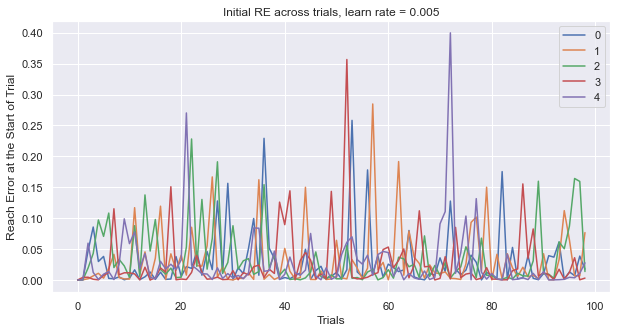

In [10]:
NUM_TRIALS = 100
NUM_RUNS = 2 # Has to be >1 # 2 = goes through the trial for target once
NUM_SESSIONS = 5
# rate_list = [5e-3, 1e-3, 5e-4, 1e-4]
rate_list = [5e-3]
A_RATE = 5e-5
K_RATE = 5e-5
ADAPT_TRIALS = NUM_TRIALS
ADAPT_DEC = False

# initialization
cursor_start = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
cursor_end = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
target_trial = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
lambda_trial = np.zeros( (NUM_NEURONS, NUM_LAMBDA, NUM_TRIALS, NUM_SESSIONS) )
fr_trial = np.zeros( (NUM_NEURONS, 1, NUM_TRIALS) )
a_trial = np.zeros( (NUM_DIM, NUM_TRIALS, NUM_SESSIONS) )
k_trial = np.zeros( (NUM_DIM, NUM_NEURONS, NUM_TRIALS, NUM_SESSIONS) )
re_startT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )
re_endT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )


for lambda_rate in rate_list:
    for iS in range(NUM_SESSIONS):
        print("")
        print("+++++++++++++++++++++++++++++++++++")
        print("Session #" + str(iS))
        ## BRAIN SIDE
        FR_DIST = (FR_SIGMA, FR_DELTA, FR_DIST_SIZE)
    #     fr_init[:, 0] = np.array(brainFiringRate(lambda_init, TARGET_VECTOR_ERR))

        ## DECODER SIDE
        A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
        K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)

        # target position -- new target represents a new trial
        target_trial[:, :, 0, iS] = TARGET_VECTOR
        print("target at trial 0 = " + str(target_trial[:, :, 0, iS]))

        print("K MATX INIT= " + str(K_MATX))
        print("A VECT INIT = " + str(A_VECT))

        ## VECTORS FOR TRIALS    
        lambda_trial[:, :, 0, iS] = lambda_init
        print("lambda")
        print(lambda_trial[:, :, 0, iS])

        a_trial[:, 0, iS] = np.array(A_VECT)
        print("a")
        print(a_trial[:, 0, iS])

        k_trial[:,:, 0, iS] = K_MATX
        print("K")
        print(k_trial[:,:, 0, iS] )
        decoder_params = (a_trial[:, 0, iS], A_RATE, A_DIST, k_trial[:,:,  0, iS], K_RATE, K_DIST)
        decoder_vals = (A_VECT, K_MATX)
        

        for iT in range(NUM_TRIALS-1):
            print("")
            print("=========================================")
            print("Trial #" + str(iT) + " | lambda learn rate = " + str(lambda_rate))
            print("Target = " + str(target_trial[:, :, iT, iS]))

            # calculate firing rate given lambda and decoder parameters with current target position 
            fr_start = np.array(brainFiringRate(lambda_trial[:, :, iT, iS], target_trial[:, :, iT, iS]))
            fr_trial[:, :, iT] = fr_start
            
            print("lambda start of trial = " + str(lambda_trial[:, :, iT, iS]))
            # calculate reach error of firing rate at the beginning of the trial
            # this becomes the error of the new target position being presented and where the cursor is
            brain_vars = ( fr_trial[:, :, iT],  target_trial[:, :, iT, iS] )
            cost_func_params = (decoder_vals, brain_vars) 
            
            re_startT[iT, iS] = error_costFunc(cost_func_params)

    #         (a_vect_in, k_matx_in) = decoder_params
            cursor_start[ :, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
            print("cursor start = " + str(cursor_start[:, :, iT, iS]) )
            print("decoder vals start = " + str(decoder_vals))

            # Run through trial and see the reach at the end        
            # current brain and decoder params
            brain_params = (fr_trial[:, :, iT], FR_DIST, lambda_trial[:, :, iT, iS], lambda_rate)
            decoder_params = (a_trial[:, iT, iS], A_RATE, A_DIST, k_trial[:, :,  iT, iS], K_RATE, K_DIST)

            # adapt brain and decoder (together here)
            a_run, k_run = calcNextDecoder(decoder_params, brain_vars)
            if (KW_only):
                a_run = np.zeros((2, 1))
            fr_run, lambda_run = calcNextBrain(brain_params, decoder_params, target_trial[:, :, iT, iS], NUM_RUNS)
            
    #         print("fr_run = " + str(fr_run))
#             re_run, fr_run, lambda_run = brain_adapt_sgd(brain_params, decoder_params, target_trial[:, :, iT], NUM_RUNS)
            # update cost function arguments
            decoder_vals = (a_run, k_run)
            brain_vars = (fr_run, target_trial[:, :, iT, iS])
            # see how the updated decoder and brain paramters have done with the current
            # target position (so target at trial = iT)
            cost_func_params = (decoder_vals, brain_vars) 
            re_run = np.array(error_costFunc(cost_func_params))

            # So what are the end trial metrics?
            if (KW_only):
                lambda_run[:, 0] = 0
            cursor_end[:, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
#             print("fr end of trial = " + str(fr_run))
            print("lambda end of trial = " + str(lambda_run))
            print("cursor end = " + str(cursor_end[:, :, iT, iS]) )

            re_endT[iT, iS] = re_run
#             print("re end = " + str(re_endT[iT, iS]))
#             print("re diff = " + str(re_endT[iT, iS] - re_startT[iT, iS]))

            # update the parameters
            lambda_trial[:, :, iT + 1, iS] = np.squeeze(lambda_run)
            a_trial[:, iT + 1, iS] = np.squeeze(a_run)
            k_trial[:, :, iT + 1, iS] = np.squeeze(k_run)
            print("a = " + str(a_trial[:, iT + 1, iS]))
            print("k = " + str(k_trial[:, :, iT + 1, iS]))

            # change to new target
            target_trial[:, 0, iT + 1, iS] = findNextTarget( cursor_end[:, :, iT, iS], target_trial[:, :, iT, iS] )
    
        
        pidx = rate_list.index(lambda_rate)
        plt.figure(2*pidx + 1, figsize=(fig_x, fig_y))
        plt.plot(np.arange(0, NUM_TRIALS-1, 1), re_startT[0:len(re_startT)-1, iS], label = '' + str(iS))
        plt.legend()
        plt.xlabel('Trials')
        plt.ylabel('Reach Error at the Start of Trial')
        plt.title('Initial RE across trials, learn rate = ' + str(lambda_rate))

    

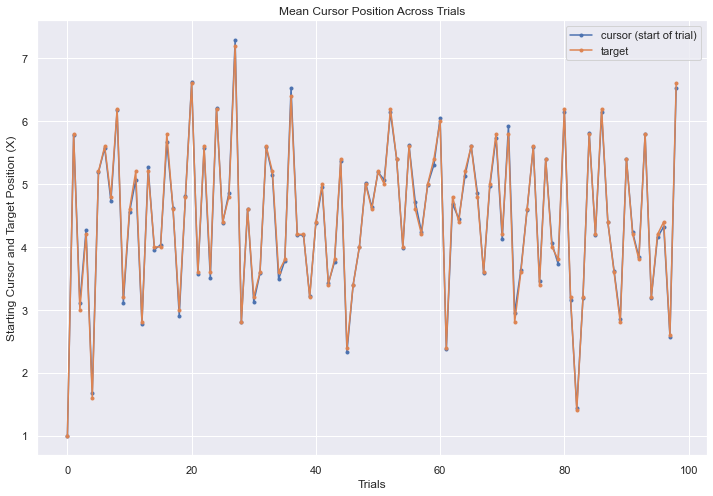

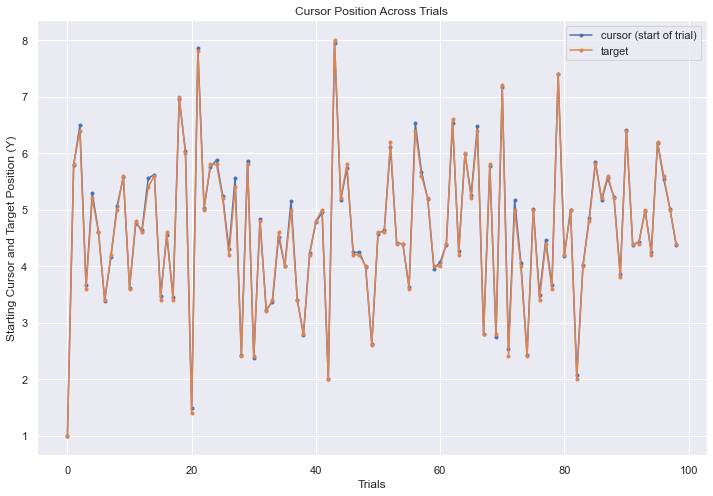

In [11]:
x = 0
y = 1

plt.figure(figsize = (12, 8))
start_x_mean = np.mean(cursor_start, axis=3)[x, 0, 0:NUM_TRIALS-1]
end_x_mean = np.mean(cursor_end, axis=3)[x, 0, 0:NUM_TRIALS-1]
start_y_mean = np.mean(cursor_start, axis=3)[y, 0, 0:NUM_TRIALS-1]
end_y_mean = np.mean(cursor_end, axis=3)[y, 0, 0:NUM_TRIALS-1]
targ_x_mean = np.mean(target_trial, axis=3)[x, 0, 0:NUM_TRIALS-1]
targ_y_mean = np.mean(target_trial, axis=3)[y, 0, 0:NUM_TRIALS-1]

plt.plot(start_x_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (X)')
plt.title('Mean Cursor Position Across Trials')
plt.show()

# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_x_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (X)')
# plt.title('Cursor Position Across Trials')
# plt.show()

plt.figure(figsize = (12, 8))
plt.plot(start_y_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (Y)')
plt.title('Cursor Position Across Trials')
plt.show()

# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_y_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (Y)')
# plt.title('Cursor Position Across Trials')
# plt.show()

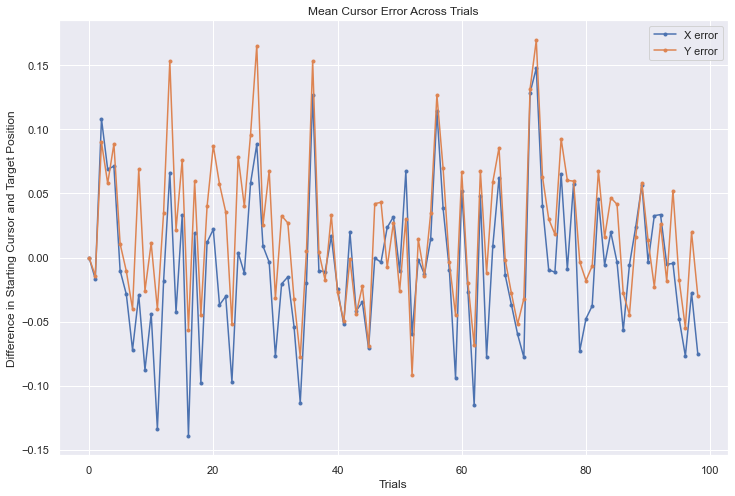

In [12]:
plt.figure(figsize = (12, 8))
plt.plot(start_x_mean - targ_x_mean, linestyle = '-', marker = '.', label = 'X error')
plt.plot(start_y_mean - targ_y_mean, linestyle = '-', marker = '.', label = 'Y error' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Difference in Starting Cursor and Target Position')
plt.title('Mean Cursor Error Across Trials')
plt.show()

Text(0.5, 1.0, 'Mean KW Matrix (1,1)')

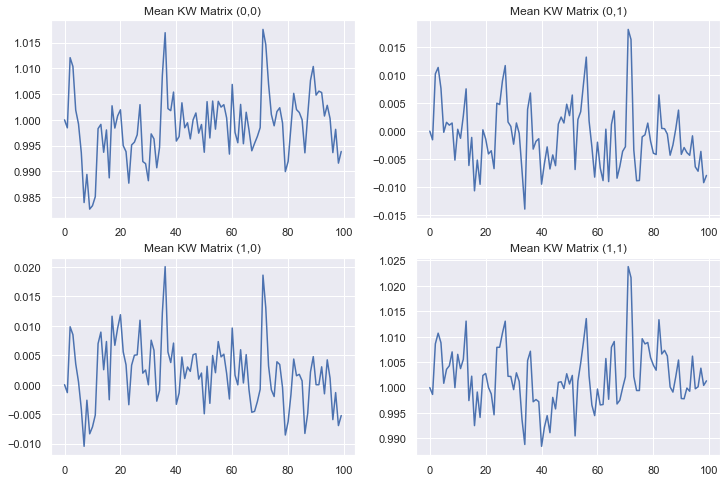

In [13]:
# print(np.shape(lambda_trial))
# print(np.shape(k_trial))
# print(np.shape((k_trial[:, :,1])))
# print(np.shape((lambda_trial[:, 1:3, 1])))

lk_mtx = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS))
lk_mtx_temp = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS, NUM_SESSIONS))
# print(np.shape((k_trial[:,:, :, 1])))
# print((lambda_trial[:, 1:3, 1, 1]))
for iT in range(NUM_TRIALS):
    for iS in range(NUM_SESSIONS):
        lk_mtx_temp[:,:, iT, iS] = np.matmul(k_trial[:,:, iT, iS], lambda_trial[:, 1:3, iT, iS])
    lk_mtx = np.mean(lk_mtx_temp[:,:, :, :], axis=3)

 
plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, :])
plt.title("Mean KW Matrix (0,0)")

plt.subplot(222)
plt.plot(lk_mtx[0, 1, :])
plt.title("Mean KW Matrix (0,1)")

plt.subplot(223)
plt.plot(lk_mtx[1, 0, :])
plt.title("Mean KW Matrix (1,0)")

plt.subplot(224)
plt.plot(lk_mtx[1, 1, :])
plt.title("Mean KW Matrix (1,1)")


Text(0.5, 1.0, 'Mean KW Matrix (1,1) | Last 100 Trials ')

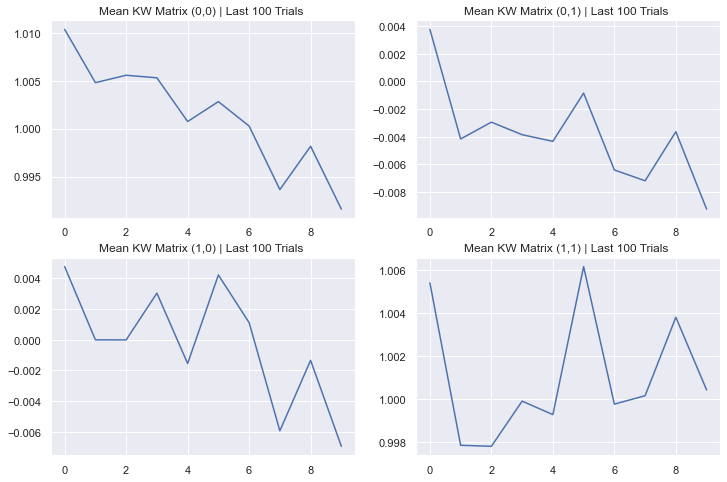

In [14]:
last = 10

plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,0) | Last 100 Trials ")

plt.subplot(222)
plt.plot(lk_mtx[0, 1,  NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,1) | Last 100 Trials ")

plt.subplot(223)
plt.plot(lk_mtx[1, 0,  NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,0) | Last 100 Trials ")

plt.subplot(224)
plt.plot(lk_mtx[1, 1,  NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,1) | Last 100 Trials ")


In [15]:
print("Average Reach Error Per Session:")

for iS in range(NUM_SESSIONS):
    print("Session # " + str(iS) + "| RE = " + str(np.mean(re_startT[:, iS])))

Average Reach Error Per Session:
Session # 0| RE = 0.029127347125254957
Session # 1| RE = 0.031236005933748222
Session # 2| RE = 0.03477951311238581
Session # 3| RE = 0.02621028198200524
Session # 4| RE = 0.028759664933483472
